# Practice 2

Student 1: Alejandro González Álvarez

NIA 1: 252658

Student 2: Luca Franceschi

NIA 2: 253885

Student 3: Júlia Othats-Dalès

NIA 3: 254435

# Imports

In [4]:
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Google Drive (or not)

In [5]:
# Comment if not in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# datadir = '/content/drive/My Drive/DeepLearning_2024/P2/Data/'
datadir = 'Data/'

# GPU Acceleration (or not)

In [6]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Ex.1 - Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

In [7]:
'''
Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs
Steps :
1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.
2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:
  -   Adapt the classification loss and the SequenceClassifier module
  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix
3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.
4. Visualize analyse and discuss the results in the report.
'''

"\nExperimenting with Multi-Class Sequence Classification using RNNs and LSTMs\nSteps :\n1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.\n2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:\n  -   Adapt the classification loss and the SequenceClassifier module\n  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix\n3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.\n4. Visualize analyse and discuss the results in the report.\n"

# Sol 1.

Train Seqs: (210, 40)
Train Labels: (210,)
Test Seqs: (90, 40)
Test Labels: (90,)


C:\Users\alex4\AppData\Local\Temp\ipykernel_22104\346631005.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


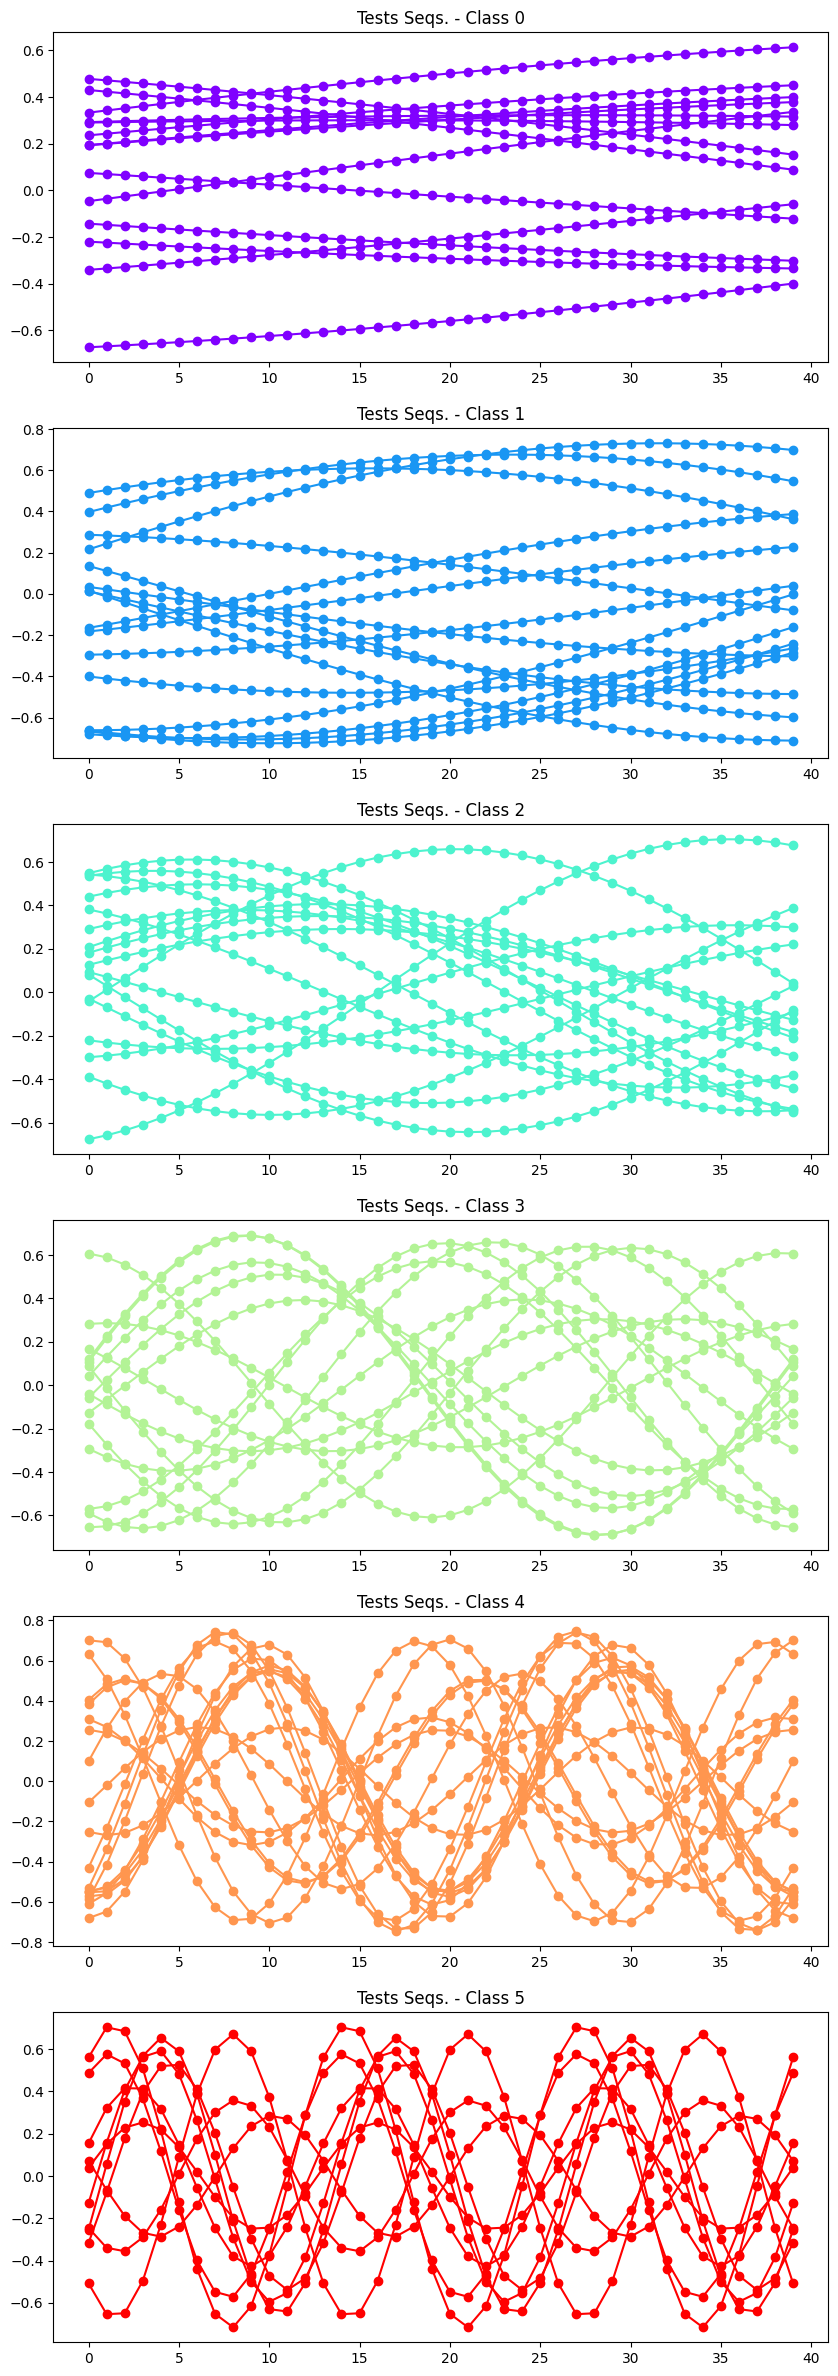

In [8]:
# 1. Load and visualize the training and testing data
data = np.load(datadir+'P2_E1.npz')
X_train, X_test = data['X_train'], data['X_test']
Y_train, Y_test = data['Y_train'], data['Y_test']

print(f'Train Seqs: {X_train.shape}')
print(f'Train Labels: {Y_train.shape}')
print(f'Test Seqs: {X_test.shape}')
print(f'Test Labels: {Y_test.shape}')

classes = np.unique(Y_train)
n_classes = len(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

fig, axs = plt.subplots(n_classes, 1, figsize=(10, 5*n_classes))
for class_idx in range(0, n_classes):
    axs[class_idx].plot(X_test[Y_test == class_idx, :].T, '-o', c=colors[class_idx])
    axs[class_idx].set_title(f'Tests Seqs. - Class {class_idx}')
fig.show()

In [9]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters

class SequenceClassifier(nn.Module):
    def __init__(self,
                 input_size : int = 1,
                 hidden_size : int = 5,
                 num_layers = 1,
                 num_classes : int = 6,
                 use_lstm : bool = False):
        # Define RNN or LSTM architecture
        super().__init__()
        self.use_lstm = use_lstm
        if(use_lstm):
            self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                               num_layers=num_layers, batch_first = True)
        else:
            self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size,
                              num_layers=num_layers, batch_first = True)
        self.softmax = nn.Softmax(dim=1)
        self.last_linear = nn.Linear(hidden_size, num_classes)  # 6 is number of different classes

    def forward(self, X):
        _, last_states = self.rnn(X)
        # Get last hidden state for last layer. Ignore cell state in case of LSTMs
        if(not self.use_lstm):
            last_hidden_state = last_states[-1,:,:].squeeze(0)
        else:
            last_hidden_state = last_states[0][-1,:,:].squeeze(0)
        # Get sequence label probability using the last hidden state
        output = self.softmax(self.last_linear(last_hidden_state))  # Using softmax instead of sigmoid
        return output

In [10]:
# Define the training model
def train_multiclass_classifier(X_train, Y_train, classifier, optimizer, loss_func, epochs=100):
    loss_epochs = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = classifier(X_train)
        loss = loss_func(output, Y_train)
        loss_epochs.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_epochs)

# Adapt the test_sequence_classifier function
def test_multiclass_classifier(X_test, Y_test, classifier):
    output = classifier(X_test)
    predicted_labels = torch.argmax(output, dim=1)
    correct_predictions = (predicted_labels == Y_test).sum().item()
    total_samples = len(Y_test)
    accuracy = correct_predictions / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y_test.to(device), predicted_labels.to(device))

    return accuracy, conf_matrix

Training: H1_NL1_LSTM0
Final loss: 1.7690258026123047
Test Accuracy: 0.2000
Training: H5_NL2_LSTM1
Final loss: 1.3681176900863647
Test Accuracy: 0.6667


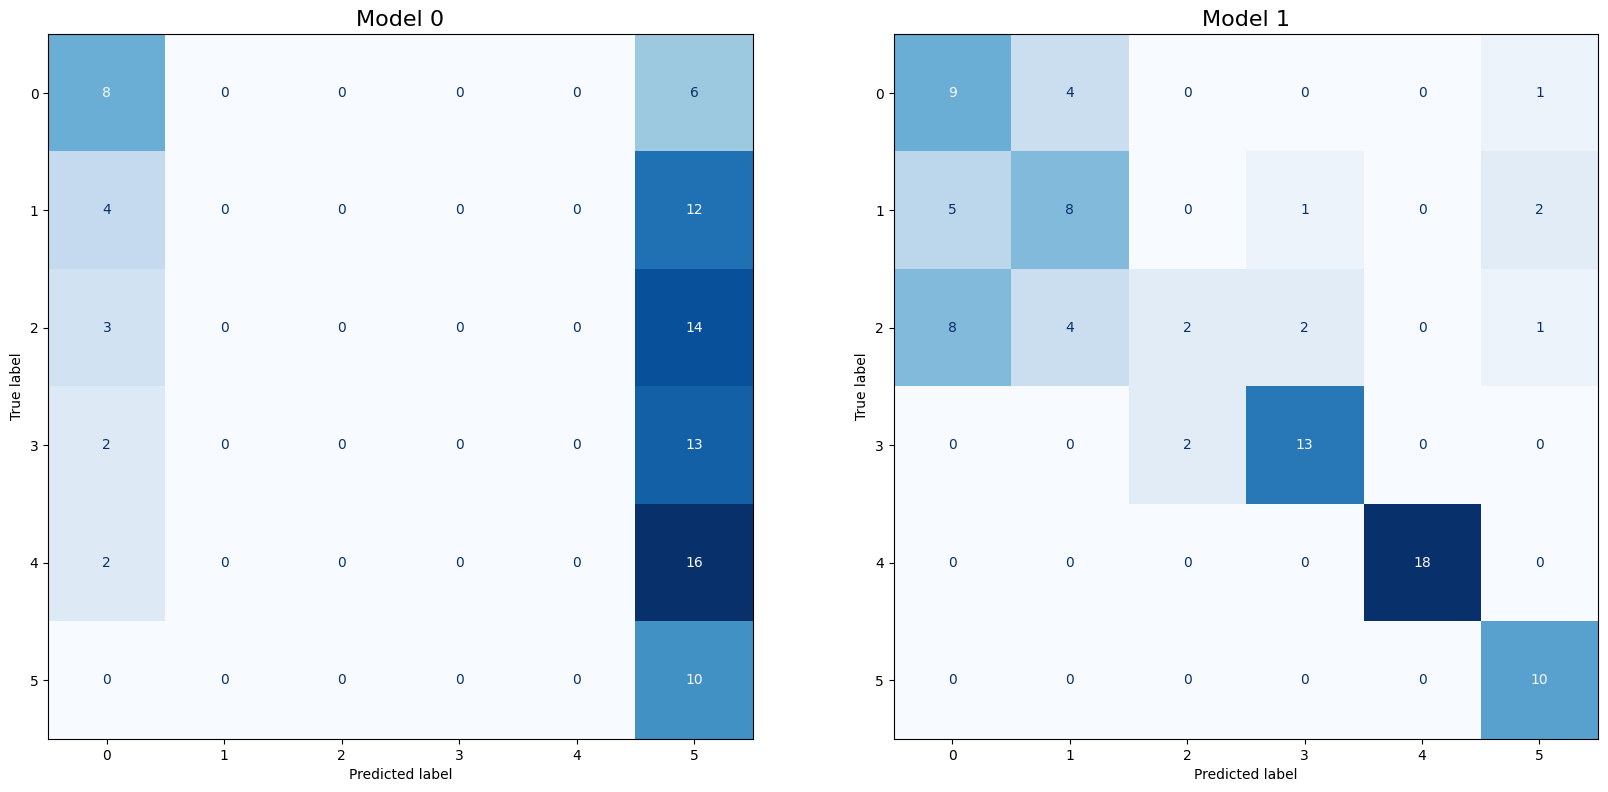

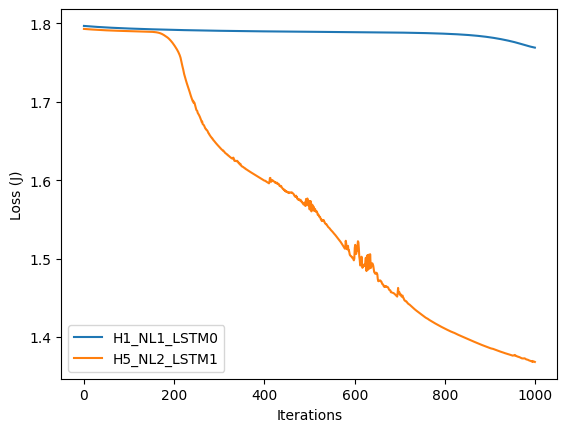

,H1_NL1_LSTM0,H5_NL2_LSTM1
accuracy %,20.0,66.666667


In [11]:
X_train_pt = torch.from_numpy(X_train).float().unsqueeze(2).to(device)
Y_train_pt = torch.from_numpy(Y_train).long().to(device)
X_test_pt = torch.from_numpy(X_test).float().unsqueeze(2).to(device)
Y_test_pt = torch.from_numpy(Y_test).long().to(device)

loss_func = nn.CrossEntropyLoss()

exp_hidden_size = [1, 5]
exp_num_layers = [1, 2]
exp_use_lstm = [False, True]

losses_models = {}
test_accuracy_models = {}
confusion_matrices = {}

for hidden_size, num_layers, use_lstm in zip(exp_hidden_size, exp_num_layers, exp_use_lstm):
    model_id = f'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
    print(f'Training: {model_id}')

    seq_classifier = SequenceClassifier(use_lstm=use_lstm, num_layers=num_layers, hidden_size=hidden_size)
    seq_classifier.to(device)

    optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=1e-3)

    losses_models[model_id] = train_multiclass_classifier(X_train_pt, Y_train_pt,
                                                          seq_classifier, optimizer,
                                                          loss_func, epochs=1000)

    test_accuracy_models[model_id], confusion_matrices[model_id] = test_multiclass_classifier(X_test_pt, Y_test_pt, seq_classifier)

#Plot confusion matrices
f, axes = plt.subplots(1, 2, figsize=(20, 20))

a = [axes[0], axes[1]]
ctr = 0
for model, cm in confusion_matrices.items():
    ConfusionMatrixDisplay(cm).plot(include_values=True, cmap="Blues", ax=a[ctr], colorbar=False, values_format=".0f")
    a[ctr].set_title("Model " + str(ctr), size=16)
    ctr += 1

plt.show()

for loss_it in losses_models.values():
    plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.xlabel("Iterations")
plt.ylabel("Loss (J)")
plt.show()

pd.DataFrame(np.asarray(list(test_accuracy_models.values()))*100, columns=['accuracy %'],
             index=test_accuracy_models.keys()).transpose()

In [12]:
# 3. Experiment with different models by changing different hyper-parameters
# (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate the results for each of them on the testing set.

# For this we will create a function that generalizes the code above, and we will change one parameter at a time in the following cells.
# IMPORTANT: this function assumes that the input are 8 HMMs at a time, it is important to put 8 as input for the plots to be displayed correctly.

def evaluateModels(exp_hidden_size, exp_num_layers, exp_use_lstm, useSGD = False, lr=1e-3, epochs=1000):
    if len(exp_hidden_size) != 8:
        print("Input 8 different models.")
        return

    losses_models = {}
    test_accuracy_models = {}
    confusion_matrices = {}
    model_ids = []

    print("------------ TRAINING ------------\n")

    for hidden_size, num_layers, use_lstm in zip(exp_hidden_size, exp_num_layers, exp_use_lstm):
        model_id = f'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
        model_ids.append(model_id)
        print(f'Training: {model_id}')

        seq_classifier = SequenceClassifier(use_lstm=use_lstm, num_layers=num_layers, hidden_size=hidden_size)
        seq_classifier.to(device)

        if (useSGD == False):
            optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=lr)
        else:
            optimizer = torch.optim.SGD(seq_classifier.parameters(), lr=lr)

        losses_models[model_id] = train_multiclass_classifier(X_train_pt, Y_train_pt,
                                                            seq_classifier, optimizer,
                                                            loss_func, epochs=epochs)

        test_accuracy_models[model_id], confusion_matrices[model_id] = test_multiclass_classifier(X_test_pt, Y_test_pt, seq_classifier)

    print("\n------------ CONFUSION MATRICES ------------\n")

    #Plot confusion matrices
    f, axes = plt.subplots(2, 4, figsize=(12, 8), constrained_layout=True)

    a = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3]]
    ctr = 0
    for model, cm in confusion_matrices.items():
        ConfusionMatrixDisplay(cm).plot(include_values=True, cmap="Blues", ax=a[ctr], colorbar=False, values_format=".0f")
        a[ctr].set_title(model_ids[ctr], size=16)
        ctr += 1

    plt.show()

    print("\n------------ LOSSES ------------\n")

    # Plot losses' evolutions
    for loss_it in losses_models.values():
        plt.plot(loss_it)
    plt.legend(losses_models.keys())
    plt.xlabel("Iterations")
    plt.ylabel("Loss (J)")
    plt.show()

    print("\n------------ ACCURACIES ------------\n")

    # Plot accuracies
    accuracy_df = pd.DataFrame(np.asarray(list(test_accuracy_models.values()))*100, columns=['accuracy %'],
                index=test_accuracy_models.keys()).transpose()
    print(accuracy_df.head())

    accuracies = np.asarray(list(test_accuracy_models.values()))
    return accuracies, exp_hidden_size, exp_num_layers, exp_use_lstm

------------ TRAINING ------------

Training: H1_NL1_LSTM0
Final loss: 1.738554835319519
Test Accuracy: 0.2000
Training: H5_NL1_LSTM0
Final loss: 1.6263294219970703
Test Accuracy: 0.4111
Training: H10_NL1_LSTM0
Final loss: 1.6924643516540527
Test Accuracy: 0.3111
Training: H20_NL1_LSTM0
Final loss: 1.594468355178833
Test Accuracy: 0.3778
Training: H1_NL1_LSTM1
Final loss: 1.7174845933914185
Test Accuracy: 0.2000
Training: H5_NL1_LSTM1
Final loss: 1.5147194862365723
Test Accuracy: 0.5333
Training: H10_NL1_LSTM1
Final loss: 1.3108923435211182
Test Accuracy: 0.7222
Training: H20_NL1_LSTM1
Final loss: 1.3752540349960327
Test Accuracy: 0.6778

------------ CONFUSION MATRICES ------------



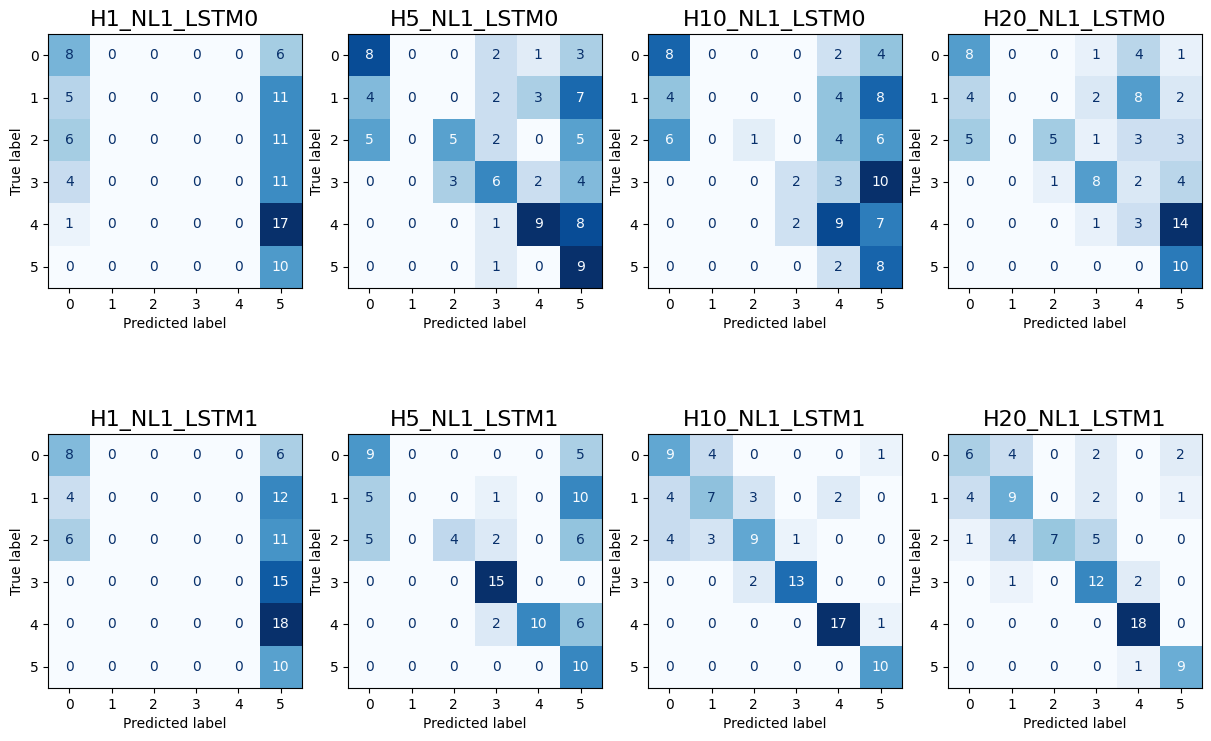


------------ LOSSES ------------



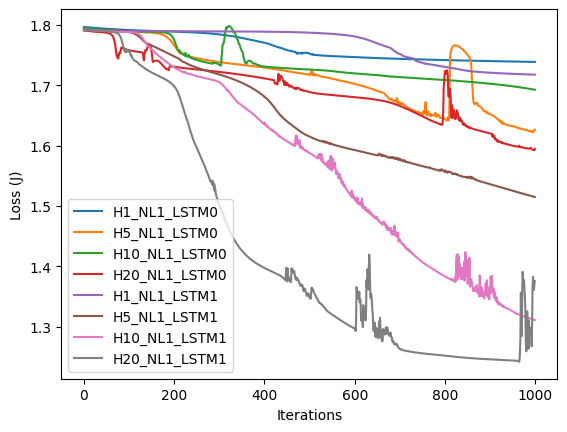


------------ ACCURACIES ------------

            H1_NL1_LSTM0  H5_NL1_LSTM0  H10_NL1_LSTM0  H20_NL1_LSTM0  \
accuracy %          20.0     41.111111      31.111111      37.777778   

            H1_NL1_LSTM1  H5_NL1_LSTM1  H10_NL1_LSTM1  H20_NL1_LSTM1  
accuracy %          20.0     53.333333      72.222222      67.777778  


In [13]:
# Testing different values for exp_hidden_size

exp_hidden_size = [1, 5, 10, 20] * 2
exp_num_layers = [1]*8
exp_use_lstm = [False]*4 + [True]*4

acc, hd_sz, num_lay, use_lstm = evaluateModels(exp_hidden_size=exp_hidden_size, exp_num_layers=exp_num_layers, exp_use_lstm=exp_use_lstm)

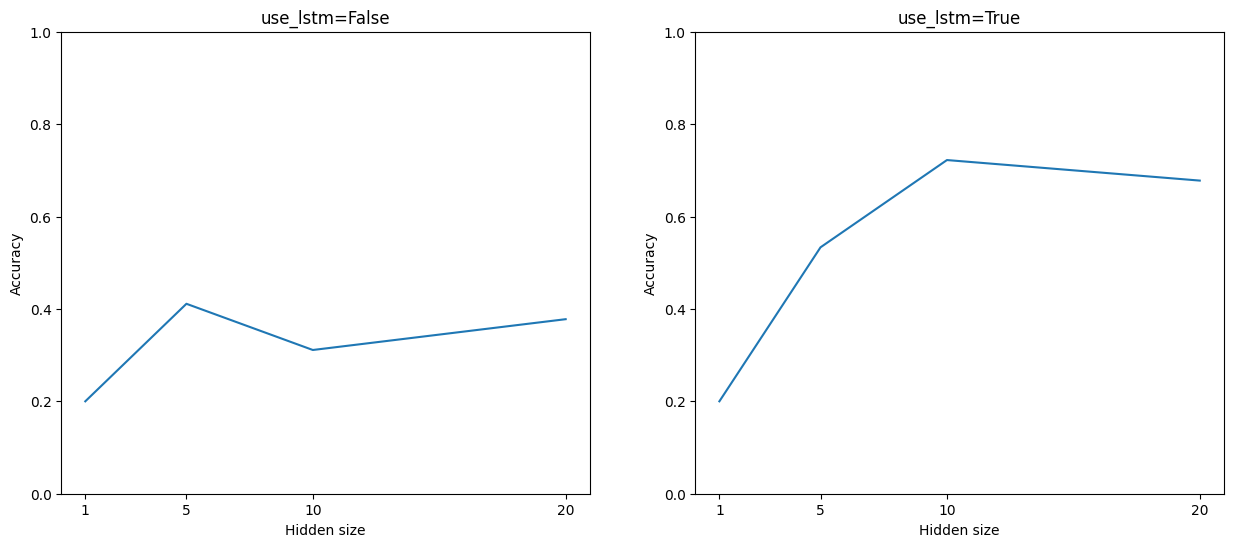

In [14]:
# Plot the evolution of accuracy with respect to hidden_size, for both lstm False and True.
f, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(hd_sz[:4], acc[:4])
axes[0].set_xlabel("Hidden size")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_title("use_lstm=False")
axes[0].set_xticks(hd_sz[:4])

axes[1].plot(hd_sz[-4:], acc[-4:])
axes[1].set_xlabel("Hidden size")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim([0, 1])
axes[1].set_title("use_lstm=True")
axes[1].set_xticks(hd_sz[-4:])

plt.show()

------------ TRAINING ------------

Training: H5_NL1_LSTM0
Final loss: 1.6430869102478027
Test Accuracy: 0.3222
Training: H5_NL2_LSTM0
Final loss: 1.624294638633728
Test Accuracy: 0.3556
Training: H5_NL3_LSTM0
Final loss: 1.632453441619873
Test Accuracy: 0.4000
Training: H5_NL4_LSTM0
Final loss: 1.51933753490448
Test Accuracy: 0.4889
Training: H5_NL1_LSTM1
Final loss: 1.518585443496704
Test Accuracy: 0.5000
Training: H5_NL2_LSTM1
Final loss: 1.6413092613220215
Test Accuracy: 0.3000
Training: H5_NL3_LSTM1
Final loss: 1.431976556777954
Test Accuracy: 0.6222
Training: H5_NL4_LSTM1
Final loss: 1.3585305213928223
Test Accuracy: 0.6333

------------ CONFUSION MATRICES ------------



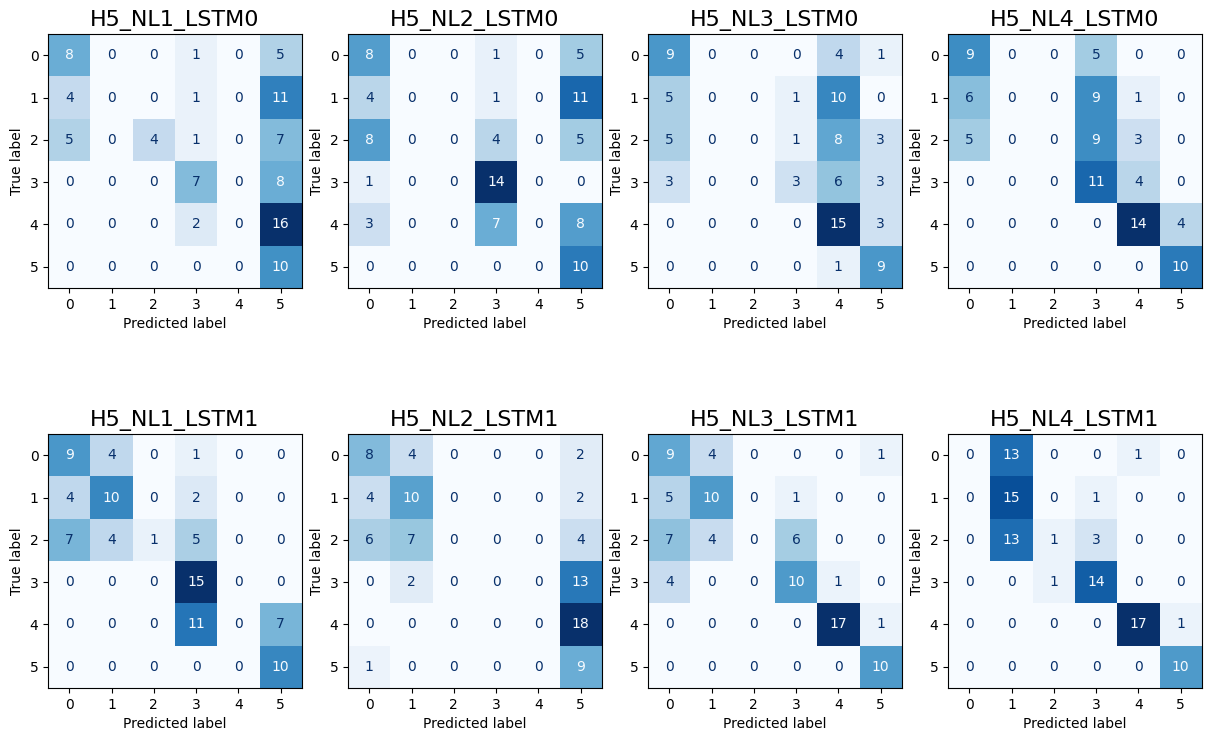


------------ LOSSES ------------



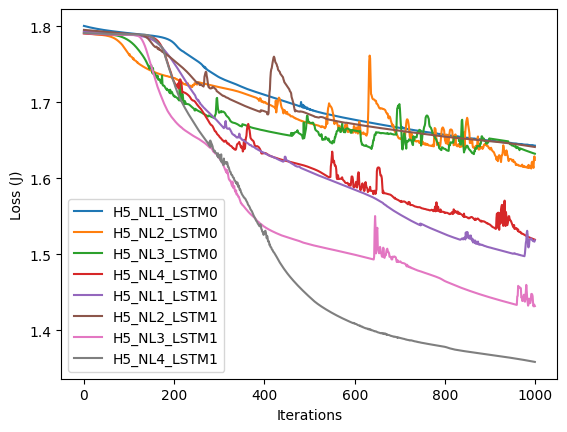


------------ ACCURACIES ------------

            H5_NL1_LSTM0  H5_NL2_LSTM0  H5_NL3_LSTM0  H5_NL4_LSTM0  \
accuracy %     32.222222     35.555556          40.0     48.888889   

            H5_NL1_LSTM1  H5_NL2_LSTM1  H5_NL3_LSTM1  H5_NL4_LSTM1  
accuracy %          50.0          30.0     62.222222     63.333333  


In [15]:
# Testing different values for exp_num_layers

exp_hidden_size = [5]*8
exp_num_layers = [1,2,3,4]*2
exp_use_lstm = [False]*4 + [True]*4

acc, hd_sz, num_lay, use_lstm = evaluateModels(exp_hidden_size=exp_hidden_size, exp_num_layers=exp_num_layers, exp_use_lstm=exp_use_lstm)

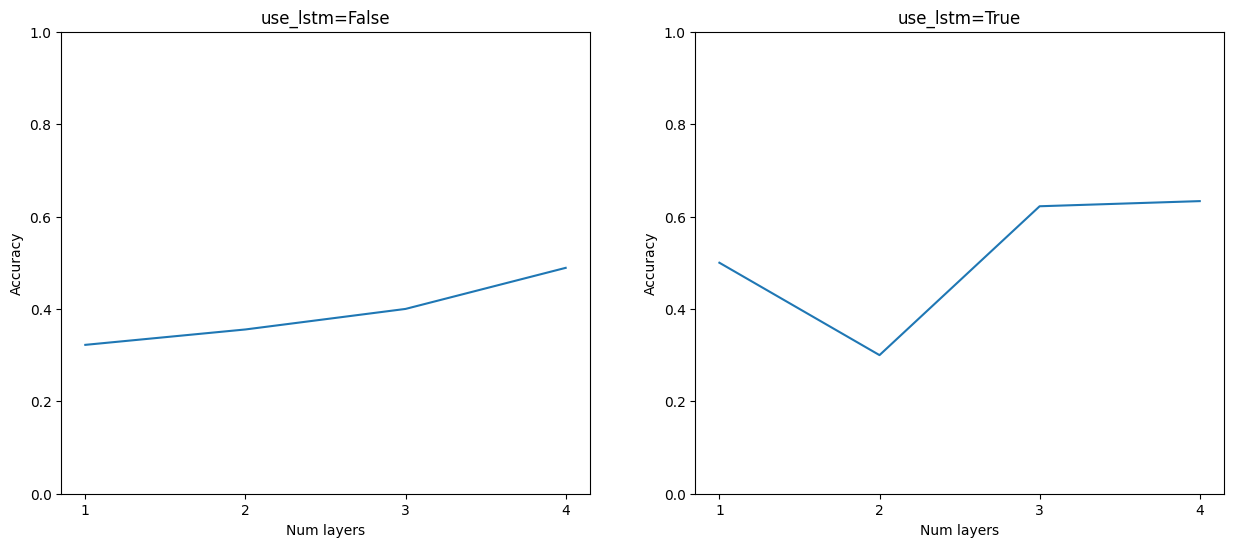

In [16]:
# Plot the evolution of accuracy with respect to num_layers, for both lstm False and True.
f, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(num_lay[:4], acc[:4])
axes[0].set_xlabel("Num layers")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_title("use_lstm=False")
axes[0].set_xticks(num_lay[:4])

axes[1].plot(num_lay[-4:], acc[-4:])
axes[1].set_xlabel("Num layers")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim([0, 1])
axes[1].set_title("use_lstm=True")
axes[1].set_xticks(num_lay[-4:])

plt.show()

------------ TRAINING ------------

Training: H1_NL1_LSTM0
Final loss: 1.790710210800171
Test Accuracy: 0.1667
Training: H5_NL1_LSTM0
Final loss: 1.7919502258300781
Test Accuracy: 0.1667
Training: H10_NL1_LSTM0
Final loss: 1.791787028312683
Test Accuracy: 0.1111
Training: H20_NL1_LSTM0
Final loss: 1.7926195859909058
Test Accuracy: 0.1778
Training: H1_NL1_LSTM1
Final loss: 1.7942571640014648
Test Accuracy: 0.1667
Training: H5_NL1_LSTM1
Final loss: 1.7908128499984741
Test Accuracy: 0.1111
Training: H10_NL1_LSTM1
Final loss: 1.7934857606887817
Test Accuracy: 0.1889
Training: H20_NL1_LSTM1
Final loss: 1.7914986610412598
Test Accuracy: 0.1000

------------ CONFUSION MATRICES ------------



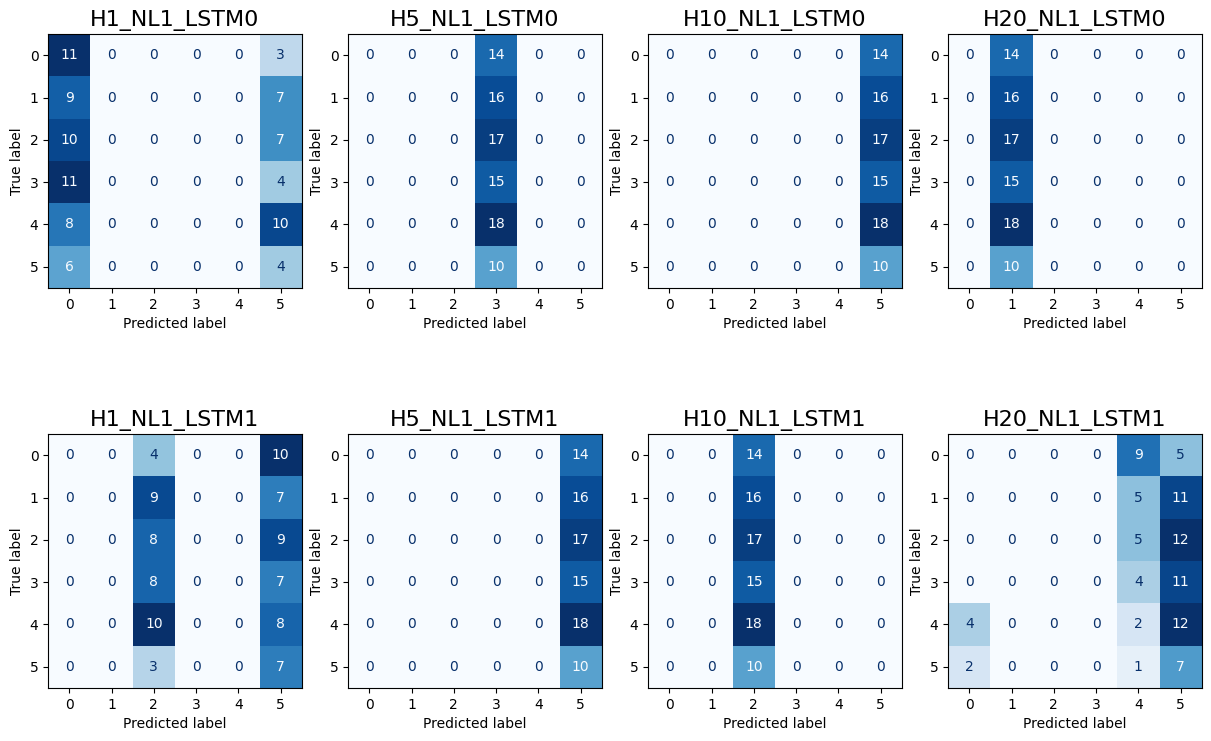


------------ LOSSES ------------



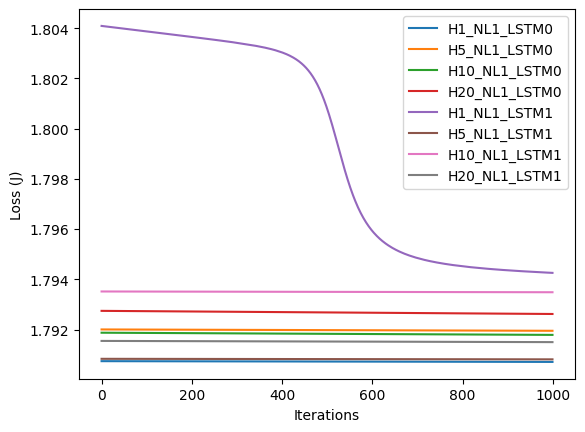


------------ ACCURACIES ------------

            H1_NL1_LSTM0  H5_NL1_LSTM0  H10_NL1_LSTM0  H20_NL1_LSTM0  \
accuracy %     16.666667     16.666667      11.111111      17.777778   

            H1_NL1_LSTM1  H5_NL1_LSTM1  H10_NL1_LSTM1  H20_NL1_LSTM1  
accuracy %     16.666667     11.111111      18.888889           10.0  


In [17]:
# Repeat experiment 1 with optimizer SGD

exp_hidden_size = [1, 5, 10, 20] * 2
exp_num_layers = [1]*8
exp_use_lstm = [False]*4 + [True]*4

acc, hd_sz, num_lay, use_lstm = evaluateModels(exp_hidden_size=exp_hidden_size, exp_num_layers=exp_num_layers, exp_use_lstm=exp_use_lstm, useSGD=True)

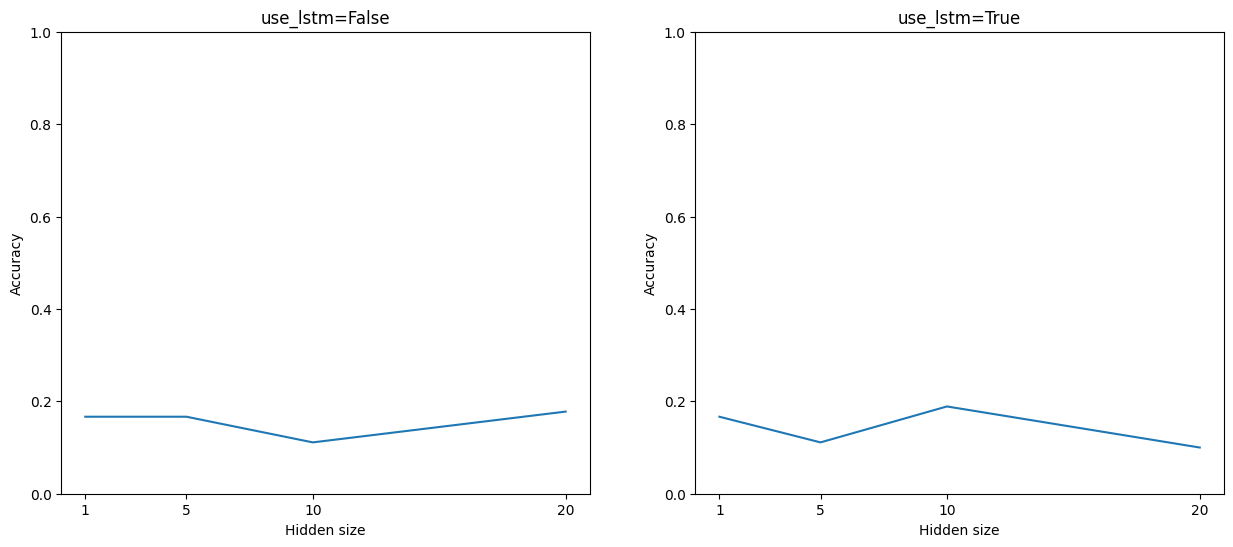

In [18]:
# Plot the evolution of accuracy with respect to hidden_size, for both lstm False and True.
f, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(hd_sz[:4], acc[:4])
axes[0].set_xlabel("Hidden size")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_title("use_lstm=False")
axes[0].set_xticks(hd_sz[:4])

axes[1].plot(hd_sz[-4:], acc[-4:])
axes[1].set_xlabel("Hidden size")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim([0, 1])
axes[1].set_title("use_lstm=True")
axes[1].set_xticks(hd_sz[-4:])

plt.show()

------------ TRAINING ------------

Training: H20_NL3_LSTM1
Final loss: 1.1192238330841064
Test Accuracy: 0.8333

------------ CONFUSION MATRICES ------------



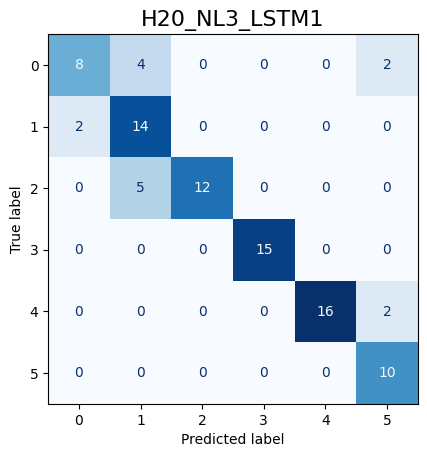


------------ LOSSES ------------



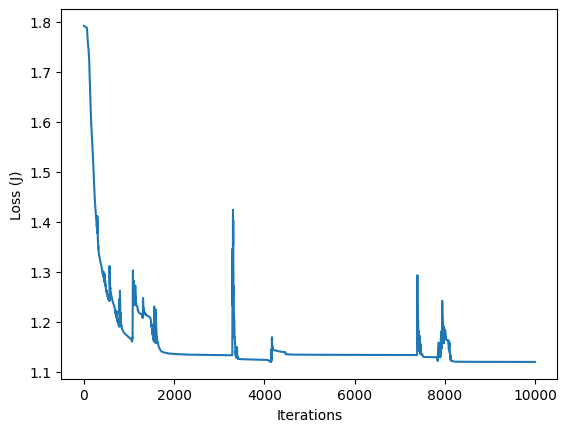


------------ ACCURACIES ------------

            H20_NL3_LSTM1
accuracy %      83.333333


In [19]:
# Final chosen model

# Define parameters
exp_hidden_size = 20
exp_num_layers = 3
exp_use_lstm = True
lr = 7e-4
epochs = 10000

print("------------ TRAINING ------------\n")

model_id = f'H{exp_hidden_size}_NL{exp_num_layers}_LSTM{int(exp_use_lstm)}'
print(f'Training: {model_id}')

seq_classifier = SequenceClassifier(use_lstm=exp_use_lstm, num_layers=exp_num_layers, hidden_size=exp_hidden_size)
seq_classifier.to(device)

optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=lr)

loss_model = train_multiclass_classifier(X_train_pt, Y_train_pt,
                                                    seq_classifier, optimizer,
                                                    loss_func, epochs=epochs)

test_accuracy_model, conf_matrix = test_multiclass_classifier(X_test_pt, Y_test_pt, seq_classifier)

print("\n------------ CONFUSION MATRICES ------------\n")

#Plot confusion matrices

ConfusionMatrixDisplay(conf_matrix).plot(include_values=True, cmap="Blues", colorbar=False, values_format=".0f")
plt.title(model_id, size=16)

plt.show()

print("\n------------ LOSSES ------------\n")

# Plot losses' evolutions
plt.plot(loss_model)
plt.xlabel("Iterations")
plt.ylabel("Loss (J)")
plt.show()

print("\n------------ ACCURACIES ------------\n")

# Plot accuracies
accuracy_df = pd.DataFrame(test_accuracy_model*100, columns=['accuracy %'],
            index=[model_id]).transpose()
print(accuracy_df.head())

# Ex 2. Cryptoanalysis with corrupted messages using RNNs/LSTMs

In [4]:
'''
Similar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis.

For this exercise, you have training.pkl and testing_corrupted.pkl files.
These files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test.
Similar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with
7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted
with a new char ("-"), while the training set has been transmitted correctly.

Each 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.

Example:

Received Ciphertext:   'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH'
Correct Ciphertext (Not provided):   'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH'
Ground truth:   'HEWENTALLOUTANDGAVEITHISBESTSHOT'

Steps :
1. Discover the keyword used to encrypt the plaintext data. (hint: use Vigenère table and some samples)
2. Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples ( to be discussed in class )
3. Train a sequential model to decode the corrupted test data.
4. Evaluate the decoding accuracy for the test set in terms of characters that were not corrupted or corrupted independently.
5. Try to improve the performance by applying some improvements over the model: stacked LSTMs,
hidden_sizes, embedding_size, optimizer, data augmentation during training, etc...
6. Visualize and discuss on the final results.
'''

'\nSimilar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis.\n\nFor this exercise, you have training.pkl and testing_corrupted.pkl files.\nThese files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test.\nSimilar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with\n7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted\nwith a new char ("-"), while the training set has been transmitted correctly.\n\nEach 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.\n\nExample:\n\nReceived Ciphertext:   \'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH\'\nCorrect Ciphertext (Not provided):   \'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH\'\nGround truth:   \'HEWENTALLOUTANDGAVEITHISBESTSHOT\'\n\nSteps :\n1. Discover the keyword used to encrypt the plaintext data. (hint: use 

In 2. being robust means getting at least 87.5% accuracy (all non corrupt chars).

For 3. we should have 2 losses, and 2 accuracies, 1 for normal chars, and 1 for corrupted chars. We should try to get 95% accuracy, 100% of the 87,5% correct chars and more or less 50% of corrupted chars are solved correctly.

Advice: do data augmentation/transformation to try to make the training data look more like the testing data.

# Sol 2.

## 1. Discover the keyword used to encrypt the plaintext data

In [20]:
# Load train and test files into memory
pkl_file = open(datadir+'training.pkl', 'rb')
train = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(datadir+'testing_corrupted.pkl', 'rb')
test = pickle.load(pkl_file)
pkl_file.close()

vocabulary = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'] # Predefined vocabulary

In [21]:
def int_to_vocabulary(message, vocabulary):
    decoded = ''
    for letter_code in message:
        decoded += vocabulary[letter_code]
    return decoded

In [22]:
keyword = (train[0][0]-train[0][1]) % len(vocabulary)
print(f'Train Message encrypted:       {int_to_vocabulary(train[0][0],vocabulary)}')
print( 'The keyword for en/decryption: {kw}'.format(kw=int_to_vocabulary(keyword, vocabulary)))
print(f'Train Message decrypted:       {int_to_vocabulary(train[0][1],vocabulary)}')
print('\nThe keyword (length {l}) is: {kw}'.format(l=7, kw=int_to_vocabulary(keyword, vocabulary)[:7]))

Train Message encrypted:       XJEQRNSIFXAKQTDPKCNYOTLBQFOLQYVY
The keyword for en/decryption: PYTORCHPYTORCHPYTORCHPYTORCHPYTO
Train Message decrypted:       ILLCALLTHEMTOMORROWWHENICOMEBACK

The keyword (length 7) is: PYTORCH


## 2.Design/Implement an strategy to train the model

Proposed strategy: train as if there was another character in the vocabulary

Problems of this strategy: this character won't be trained properly

Solution to this problem: we could intentionally corrupt training data so the model learns how to interpret those appropiately

In [23]:
corr_vocab = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-'] # Corrupted vocabulary

In [24]:
class CorruptedDataset(Dataset):
    # the data is in the form [img_name, boundaries]
    def __init__(self, data, p=0.125, corrupted_char=26):
        self.data = data.to(device)
        self.corr_prob = p
        self.corr_char = corrupted_char
        self.shape = data.shape
        self.batch_size = None

        def corrupt_tensor(tensor):
            corrupted_idx = np.random.uniform(size=tensor.shape[0]) < self.corr_prob # Get random indexes for a sample with prob=corrupted_probability
            corr_item = tensor.clone()
            corr_item[corrupted_idx==True] = self.corr_char # Modify selected characters to the corrupted character
            return corr_item
        self.transform = corrupt_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx])

In [25]:
class CorruptedDecrypterNetwork(nn.Module):
    def __init__(self,
                 hidden_size : int = 8,
                 num_layers = 1,
                 num_letters = 26,
                 letters_embedding_size : int = 8,
                 use_lstm : bool = False):
        # Define RNN or LSTM architecture
        super().__init__()
        self.hidden_size = hidden_size
        self.num_letters = num_letters
        self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)
        self.use_lstm = use_lstm
        self.softmax = nn.Softmax(dim=1)
        if(use_lstm):
            self.rnn = nn.LSTM(input_size = letters_embedding_size, hidden_size = hidden_size,
                               num_layers=num_layers, batch_first = True)
        else:
            self.rnn = nn.RNN(input_size = letters_embedding_size, hidden_size = hidden_size,
                              num_layers=num_layers, batch_first = True)
        self.last_linear = nn.Linear(hidden_size,num_letters)

    def forward(self, X):
        N = X.shape[0]
        L = X.shape[1]
        embedded_letters = self.letters_embedder(X)
        # Get hidden states for all letters in the sequence
        hidden_states,_ = self.rnn(embedded_letters)
        # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
        hidden_states_concat = hidden_states.reshape(-1,self.hidden_size)
        # Get letters probability using the hidden states for each position in the sequence
        letters_loggits = self.last_linear(hidden_states_concat)
        # Use soft-max over logits and reshape to format (N,L,num_letteres)
        letters_probs = self.softmax(letters_loggits).reshape(N, L, self.num_letters)
        return letters_probs

## 3-4. Training and testing

In [26]:
def train_test(model, num_epochs, loss_fn, optimizer,
            train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted):

    model = model.to(device)
    # train_encrypted_loader = train_encrypted_loader.data.to(device)
    train_decrypted = train_decrypted.to(device)
    test_encrypted = test_encrypted.to(device)
    test_decrypted = test_decrypted.to(device)

    # Note that what were lists are now dictionaries to not return 12 elements
    train_loss_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }
    test_loss_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }
    train_acc_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }
    test_acc_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }

    # Get corrupted indexes for the test dataset (always the same)
    test_corr_idxs = (test_encrypted == train_encrypted_loader.dataset.corr_char).nonzero(as_tuple=True)
    test_non_corr_idxs = (test_encrypted != train_encrypted_loader.dataset.corr_char).nonzero(as_tuple=True)

    for epoch in range(num_epochs):
        # TRAINING AND BACK-PROPAGATION
        model.train()
        optimizer.zero_grad()
        batch = next(iter(train_encrypted_loader)) # Get whole augmented dataset (in a single batch)
        letters_probs = model(batch)
        train_loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                                        train_decrypted)
        train_loss.backward() # Backpropagate
        optimizer.step() # Update weights

        # Get corrupted indexes for the batch (always changing)
        corr_idxs = (batch == train_encrypted_loader.dataset.corr_char).nonzero(as_tuple=True)
        non_corr_idxs = (batch != train_encrypted_loader.dataset.corr_char).nonzero(as_tuple=True)

        # Split train loss into corrupted and non-corrupted for visualization
        train_loss_hist["overall"].append(train_loss.item())
        train_loss_hist["corrupted"].append(loss_fn(letters_probs[corr_idxs].log(), train_decrypted[corr_idxs]).item())
        train_loss_hist["non-corrupted"].append(loss_fn(letters_probs[non_corr_idxs].log(), train_decrypted[non_corr_idxs]).item())

        # Split train accuracy into corrupted and non-corrupted for visualization
        _, maxprob_letters_idx = letters_probs.max(dim=2) # get letter with maximum prob
        train_acc_hist["overall"].append(((maxprob_letters_idx==train_decrypted)*1.0).mean().item())
        train_acc_hist["corrupted"].append(((maxprob_letters_idx[corr_idxs]==train_decrypted[corr_idxs])*1.0).mean().item())
        train_acc_hist["non-corrupted"].append(((maxprob_letters_idx[non_corr_idxs]==train_decrypted[non_corr_idxs])*1.0).mean().item())

        # EVALUATION
        model.eval()
        letters_probs = model(test_encrypted)
        test_loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                                                test_decrypted)

        # Split test loss into corrupted and non-corrupted for visualization
        test_loss_hist["overall"].append(test_loss.item())
        test_loss_hist["corrupted"].append(loss_fn(letters_probs[test_corr_idxs].log(), test_decrypted[test_corr_idxs]).item())
        test_loss_hist["non-corrupted"].append(loss_fn(letters_probs[test_non_corr_idxs].log(), test_decrypted[test_non_corr_idxs]).item())

        # Split test accuracy into corrupted and non-corrupted for visualization
        _, maxprob_letters_idx = letters_probs.max(dim=2) # get letter with maximum prob
        test_acc_hist["overall"].append(((maxprob_letters_idx==test_decrypted)*1.0).mean().item())
        test_acc_hist["corrupted"].append(((maxprob_letters_idx[test_corr_idxs]==test_decrypted[test_corr_idxs])*1.0).mean().item())
        test_acc_hist["non-corrupted"].append(((maxprob_letters_idx[test_non_corr_idxs]==test_decrypted[test_non_corr_idxs])*1.0).mean().item())

        if(epoch%50==0):
            print(f'Epoch {epoch} \t Train Loss {round(train_loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(test_acc_hist["overall"][-1]*100,1)}')
    print(f'Final Epoch \t Train Loss {round(train_loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(test_acc_hist["overall"][-1]*100,1)}')
    return model, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [27]:
train_encrypted = torch.concat([train_sample[0].unsqueeze(0) for train_sample in train],dim=0)
train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in train],dim=0)
test_encrypted = torch.concat([test_sample[0].unsqueeze(0) for test_sample in test],dim=0)
test_decrypted = torch.concat([test_sample[1].unsqueeze(0) for test_sample in test],dim=0)

train_encrypted_dataset = CorruptedDataset(train_encrypted)
train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                     num_letters=len(corr_vocab),
                                     hidden_size=16,
                                     use_lstm=True)

num_epochs=1000
# weights [1/52, ..., 1/52, 1/2]
#          {   26 times   }
weights = [0.875/(len(corr_vocab)-1)]*(len(corr_vocab)-1) + [0.125]
weights = torch.Tensor(weights)
CE_loss = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

In [15]:
decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                            num_epochs,
                                                            CE_loss,
                                                            optimizer,
                                                            train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

Epoch 0 	 Train Loss 3.363 	 Test Loss 3.326 	 Test Acc. (%)  5.7
Epoch 50 	 Train Loss 2.475 	 Test Loss 2.483 	 Test Acc. (%)  27.0
Epoch 100 	 Train Loss 2.122 	 Test Loss 2.136 	 Test Acc. (%)  34.8
Epoch 150 	 Train Loss 1.878 	 Test Loss 1.893 	 Test Acc. (%)  38.3
Epoch 200 	 Train Loss 1.753 	 Test Loss 1.765 	 Test Acc. (%)  41.5
Epoch 250 	 Train Loss 1.674 	 Test Loss 1.683 	 Test Acc. (%)  44.1
Epoch 300 	 Train Loss 1.613 	 Test Loss 1.626 	 Test Acc. (%)  45.7
Epoch 350 	 Train Loss 1.569 	 Test Loss 1.582 	 Test Acc. (%)  46.7
Epoch 400 	 Train Loss 1.531 	 Test Loss 1.548 	 Test Acc. (%)  47.9
Epoch 450 	 Train Loss 1.511 	 Test Loss 1.523 	 Test Acc. (%)  48.3
Epoch 500 	 Train Loss 1.492 	 Test Loss 1.503 	 Test Acc. (%)  49.0
Epoch 550 	 Train Loss 1.475 	 Test Loss 1.487 	 Test Acc. (%)  49.5
Epoch 600 	 Train Loss 1.459 	 Test Loss 1.471 	 Test Acc. (%)  49.9
Epoch 650 	 Train Loss 1.448 	 Test Loss 1.458 	 Test Acc. (%)  50.3
Epoch 700 	 Train Loss 1.433 	 Test Lo

KeyboardInterrupt: 

## 5. Visualizing results

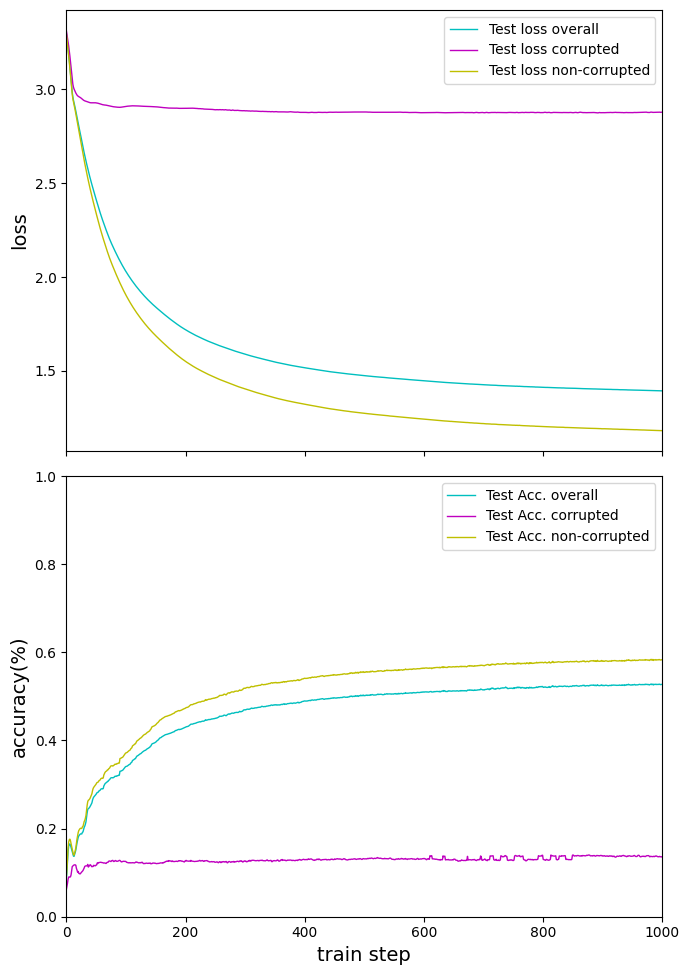

--------------------------------------
Original Message encrypted: WCPSEVHAJ----USETJVKAWGLPVUAHFHH
Message decrypted: HEWENTALLOUTANDGAVEITHISBESTSHOT
Prediction Message decrypted: HEWELTAMLEEEESENASEITHISIESTOOOT
Prediction Message Accuracy : 0.59
--------------------------------------
Original Message encrypted: BYKMJYH-RASFPS-NACEGUJK-SIVVB-TR
Message decrypted: MARYSWASTHEONLYPHONENUMBERTOMHAD
Prediction Message decrypted: MARYURASAHEONDELLELEGCIEERTEIOAT
Prediction Message Accuracy : 0.47
--------------------------------------
Original Message encrypted: -CXLGNH-LX-KQO-PAWJEPGANAJVHCAXG
Message decrypted: HEEXPLAINEDTOHERHISCIRCUMSTANCES
Prediction Message decrypted: IEENRLATEERTOHENTHSCAETYLLTANTIS
Prediction Message Accuracy : 0.47
--------------------------------------
Original Message encrypted: BYK-JJV-CWHFOAWCPC-NKUPHAKJLEYL-
Message decrypted: MARYSHOWEDTOMTHEWORLDFROMTHEPAST
Prediction Message decrypted: MARALHTEEDTOATIEWNTLINISLTHEPAST
Prediction Message Accuracy : 0.59


In [30]:
types = ['overall', 'corrupted', 'non-corrupted']
colors = {'overall': 'c', 'corrupted': 'm', 'non-corrupted': 'y'}

def plot_loss_accuracy(train_loss, train_acc, test_loss, test_acc, set='test', title=None, types=types, colors=colors):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
    fig.suptitle(title)
    for type in types:
        if set == 'test':
            ax1.plot(test_loss[type], '-'+colors[type], linewidth=1.0, label='Test loss '+type)
        elif set=='train':
            ax1.plot(train_loss[type], '-.'+colors[type], linewidth=1.0, label='Train loss '+type)
        else:
            ax1.plot(test_loss[type], '-'+colors[type], linewidth=1.0, label='Test loss '+type)
            ax1.plot(train_loss[type], '-.'+colors[type], linewidth=1.0, label='Train loss '+type)

    ax1.set_ylabel('loss', fontsize=14)
    ax1.legend()
    # plt.show()

    for type in types:
        if set == 'test':
            ax2.plot(test_acc[type], '-'+colors[type], linewidth=1.0, label='Test Acc. '+type)
        elif set=='train':
            ax2.plot(train_acc[type], '-.'+colors[type], linewidth=1.0, label='Train Acc. '+type)
        else:
            ax1.plot(test_loss[type], '-'+colors[type], linewidth=1.0, label='Test loss '+type)
            ax1.plot(train_loss[type], '-.'+colors[type], linewidth=1.0, label='Train loss '+type)
    ax2.set_xlabel('train step', fontsize=14)
    ax2.set_ylabel('accuracy(%)', fontsize=14)
    ax2.set_ylim([0, 1])
    ax2.set_xlim([0, num_epochs])
    ax2.legend()
    plt.tight_layout()
    plt.show()

plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist)

decrypter_network = decrypter_network.to(device)
for idx_sample in range(0,10):
    # Inference over single training sequence
    letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0).to(device))
    # get index of letter with max probability
    _,maxprob_letters_idx = letters_probs.max(dim=2)
    print('--------------------------------------')
    print(f'Original Message encrypted: {int_to_vocabulary(test[idx_sample][0],corr_vocab)}')
    print(f'Message decrypted: {int_to_vocabulary(test[idx_sample][1],vocabulary)}')
    print(f'Prediction Message decrypted: {int_to_vocabulary(maxprob_letters_idx[0],corr_vocab)}')
    acc = (1.0*(maxprob_letters_idx[0]==test[idx_sample][1].to(device))).mean().item()
    print(f'Prediction Message Accuracy : {round(acc,2)}')

## 6. Improving the model

In [28]:
epochs = [500, 1000, 1500]
learning_rates = [1e-2, 1e-3, 5e-4]
use_lstm = [False, True]
num_layers = [1, 2]
hidden_sizes = [8, 16, 32, 48]
corruptions = [0, 0.125, 0.2, 0.4]

In [24]:
for e in epochs:
    train_encrypted_dataset = CorruptedDataset(train_encrypted)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                        num_letters=len(corr_vocab),
                                        hidden_size=16,
                                        use_lstm=True)

    num_epochs=e
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title=str(e) + ' Epochs')


Epoch 0 	 Train Loss 3.262 	 Test Loss 3.241 	 Test Acc. (%)  12.0
Epoch 50 	 Train Loss 2.38 	 Test Loss 2.382 	 Test Acc. (%)  28.9
Epoch 100 	 Train Loss 1.976 	 Test Loss 1.985 	 Test Acc. (%)  36.9
Epoch 150 	 Train Loss 1.773 	 Test Loss 1.788 	 Test Acc. (%)  40.9


Epoch 0 	 Train Loss 3.327 	 Test Loss 3.303 	 Test Acc. (%)  4.7
Epoch 50 	 Train Loss 2.412 	 Test Loss 2.415 	 Test Acc. (%)  27.5
Epoch 100 	 Train Loss 2.009 	 Test Loss 2.026 	 Test Acc. (%)  35.7
Epoch 150 	 Train Loss 1.824 	 Test Loss 1.841 	 Test Acc. (%)  39.7
Epoch 200 	 Train Loss 1.717 	 Test Loss 1.732 	 Test Acc. (%)  43.2
Epoch 250 	 Train Loss 1.637 	 Test Loss 1.658 	 Test Acc. (%)  44.9
Epoch 300 	 Train Loss 1.586 	 Test Loss 1.605 	 Test Acc. (%)  46.1
Epoch 350 	 Train Loss 1.545 	 Test Loss 1.564 	 Test Acc. (%)  47.3
Epoch 400 	 Train Loss 1.517 	 Test Loss 1.534 	 Test Acc. (%)  48.3
Epoch 450 	 Train Loss 1.494 	 Test Loss 1.512 	 Test Acc. (%)  49.0
Epoch 500 	 Train Loss 1.474 	 Test Loss 1.492 	 Test Acc. (%)  49.9
Epoch 550 	 Train Loss 1.457 	 Test Loss 1.475 	 Test Acc. (%)  50.6
Epoch 600 	 Train Loss 1.444 	 Test Loss 1.461 	 Test Acc. (%)  51.0
Epoch 650 	 Train Loss 1.432 	 Test Loss 1.448 	 Test Acc. (%)  51.6
Epoch 700 	 Train Loss 1.42 	 Test Los

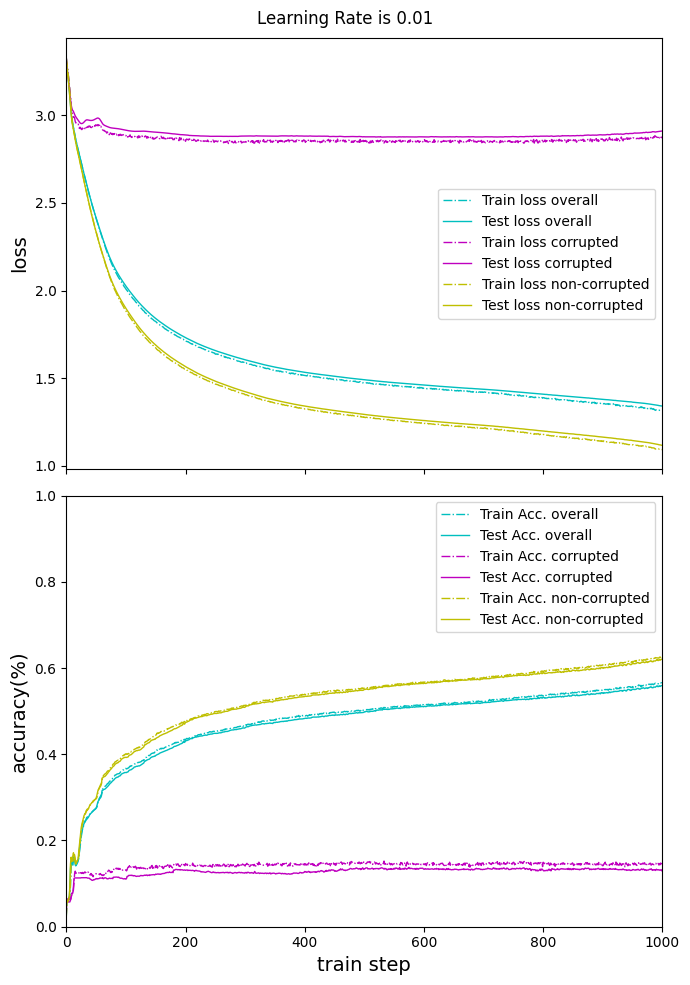

Epoch 0 	 Train Loss 3.313 	 Test Loss 3.312 	 Test Acc. (%)  3.1
Epoch 50 	 Train Loss 3.091 	 Test Loss 3.093 	 Test Acc. (%)  8.7
Epoch 100 	 Train Loss 2.904 	 Test Loss 2.913 	 Test Acc. (%)  13.0
Epoch 150 	 Train Loss 2.834 	 Test Loss 2.844 	 Test Acc. (%)  17.1
Epoch 200 	 Train Loss 2.757 	 Test Loss 2.767 	 Test Acc. (%)  17.8
Epoch 250 	 Train Loss 2.669 	 Test Loss 2.68 	 Test Acc. (%)  22.6
Epoch 300 	 Train Loss 2.574 	 Test Loss 2.585 	 Test Acc. (%)  24.2
Epoch 350 	 Train Loss 2.483 	 Test Loss 2.494 	 Test Acc. (%)  26.6
Epoch 400 	 Train Loss 2.401 	 Test Loss 2.411 	 Test Acc. (%)  27.0
Epoch 450 	 Train Loss 2.323 	 Test Loss 2.333 	 Test Acc. (%)  27.9
Epoch 500 	 Train Loss 2.255 	 Test Loss 2.264 	 Test Acc. (%)  29.2
Epoch 550 	 Train Loss 2.193 	 Test Loss 2.204 	 Test Acc. (%)  31.4
Epoch 600 	 Train Loss 2.14 	 Test Loss 2.15 	 Test Acc. (%)  32.1
Epoch 650 	 Train Loss 2.094 	 Test Loss 2.103 	 Test Acc. (%)  32.5
Epoch 700 	 Train Loss 2.051 	 Test Loss 2

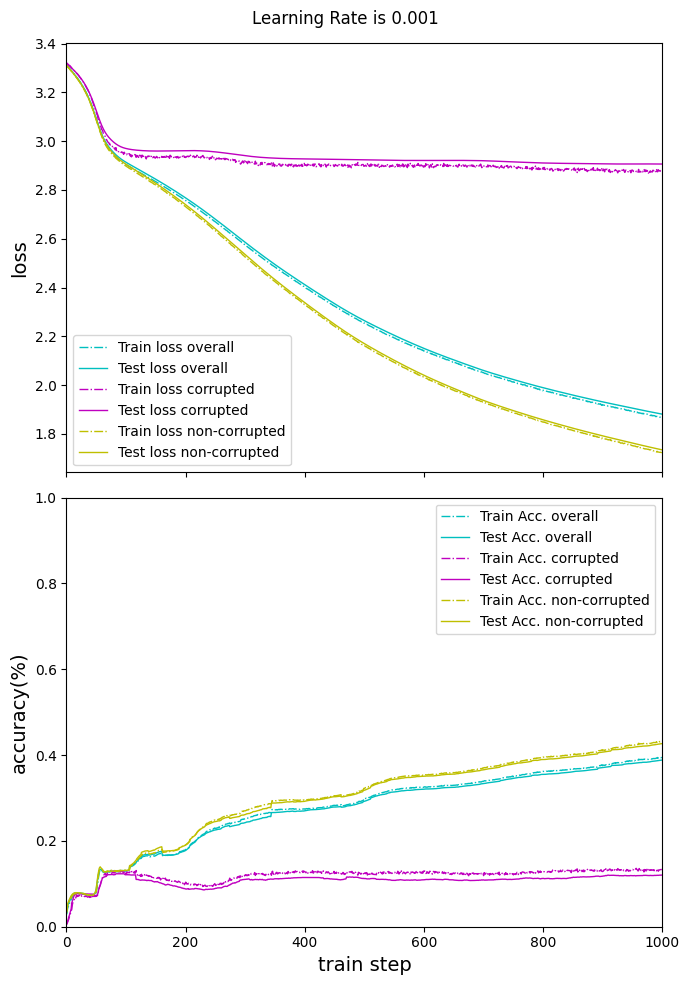

Epoch 0 	 Train Loss 3.337 	 Test Loss 3.336 	 Test Acc. (%)  1.7
Epoch 50 	 Train Loss 3.267 	 Test Loss 3.266 	 Test Acc. (%)  7.7
Epoch 100 	 Train Loss 3.143 	 Test Loss 3.145 	 Test Acc. (%)  9.0
Epoch 150 	 Train Loss 2.982 	 Test Loss 2.991 	 Test Acc. (%)  12.3
Epoch 200 	 Train Loss 2.89 	 Test Loss 2.902 	 Test Acc. (%)  17.3
Epoch 250 	 Train Loss 2.838 	 Test Loss 2.85 	 Test Acc. (%)  17.2
Epoch 300 	 Train Loss 2.789 	 Test Loss 2.802 	 Test Acc. (%)  18.4
Epoch 350 	 Train Loss 2.737 	 Test Loss 2.75 	 Test Acc. (%)  20.9
Epoch 400 	 Train Loss 2.682 	 Test Loss 2.696 	 Test Acc. (%)  22.5
Epoch 450 	 Train Loss 2.626 	 Test Loss 2.64 	 Test Acc. (%)  24.2
Epoch 500 	 Train Loss 2.569 	 Test Loss 2.584 	 Test Acc. (%)  25.2
Epoch 550 	 Train Loss 2.514 	 Test Loss 2.529 	 Test Acc. (%)  25.9
Epoch 600 	 Train Loss 2.462 	 Test Loss 2.478 	 Test Acc. (%)  27.0
Epoch 650 	 Train Loss 2.416 	 Test Loss 2.432 	 Test Acc. (%)  27.9
Epoch 700 	 Train Loss 2.374 	 Test Loss 2.3

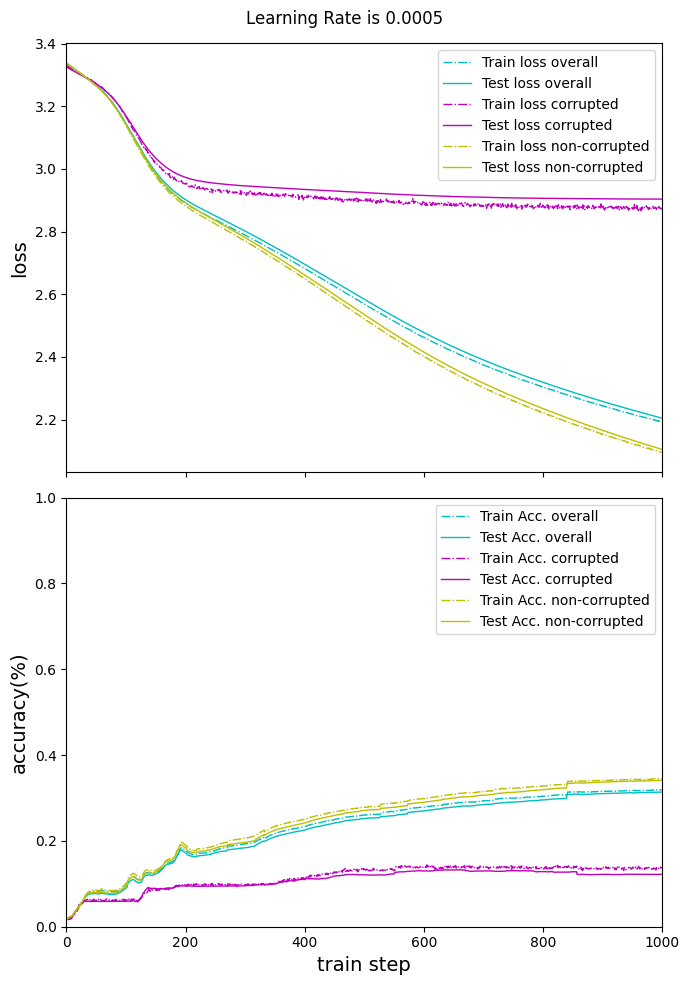

In [ ]:
for l in learning_rates:
    train_encrypted_dataset = CorruptedDataset(train_encrypted)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                        num_letters=len(corr_vocab),
                                        hidden_size=16,
                                        use_lstm=True)

    num_epochs=1000
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=l)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='Learning Rate is '+ str(l))

Epoch 0 	 Train Loss 3.296 	 Test Loss 3.268 	 Test Acc. (%)  4.5
Epoch 50 	 Train Loss 2.504 	 Test Loss 2.506 	 Test Acc. (%)  25.4
Epoch 100 	 Train Loss 2.05 	 Test Loss 2.061 	 Test Acc. (%)  33.6
Epoch 150 	 Train Loss 1.846 	 Test Loss 1.856 	 Test Acc. (%)  39.7
Epoch 200 	 Train Loss 1.727 	 Test Loss 1.736 	 Test Acc. (%)  42.7
Epoch 250 	 Train Loss 1.655 	 Test Loss 1.666 	 Test Acc. (%)  45.0
Epoch 300 	 Train Loss 1.607 	 Test Loss 1.617 	 Test Acc. (%)  46.5
Epoch 350 	 Train Loss 1.564 	 Test Loss 1.574 	 Test Acc. (%)  47.9
Epoch 400 	 Train Loss 1.531 	 Test Loss 1.541 	 Test Acc. (%)  49.0
Epoch 450 	 Train Loss 1.501 	 Test Loss 1.515 	 Test Acc. (%)  49.5
Epoch 500 	 Train Loss 1.477 	 Test Loss 1.492 	 Test Acc. (%)  50.4
Epoch 550 	 Train Loss 1.454 	 Test Loss 1.469 	 Test Acc. (%)  51.3
Epoch 600 	 Train Loss 1.429 	 Test Loss 1.445 	 Test Acc. (%)  52.5
Epoch 650 	 Train Loss 1.4 	 Test Loss 1.412 	 Test Acc. (%)  53.9
Epoch 700 	 Train Loss 1.273 	 Test Loss 

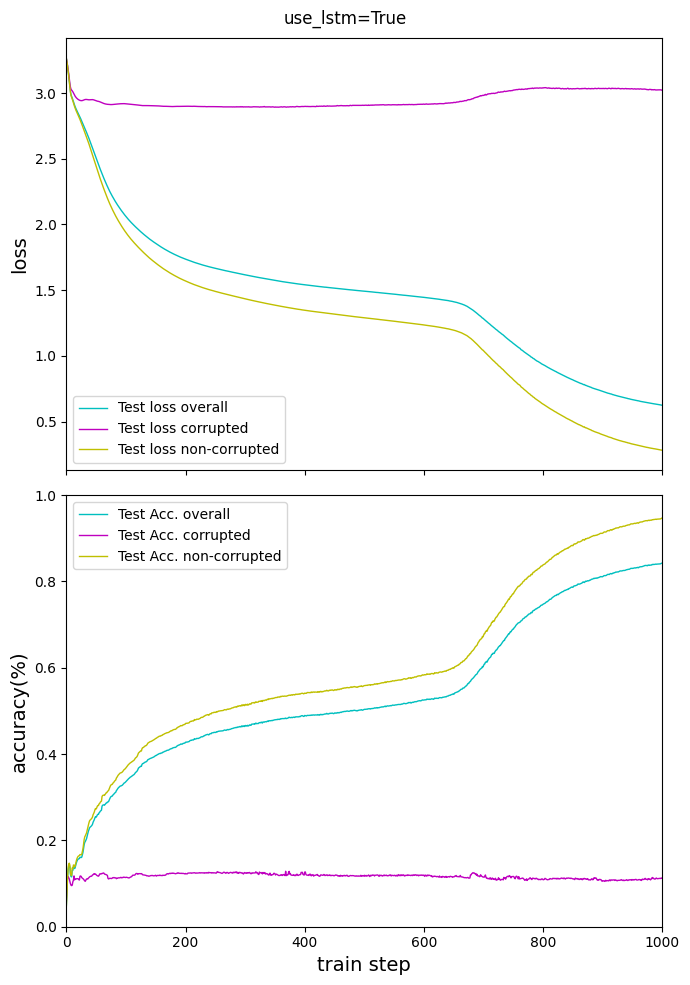

In [31]:
for r in use_lstm:
    if r == True:
        train_encrypted_dataset = CorruptedDataset(train_encrypted)
        train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

        decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                            num_letters=len(corr_vocab),
                                            hidden_size=16,
                                            use_lstm=r)

        num_epochs=1000
        optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

        decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                    num_epochs,
                                                                    CE_loss,
                                                                    optimizer,
                                                                    train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

        plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='use_lstm='+ str(r))

Epoch 0 	 Train Loss 3.314 	 Test Loss 3.313 	 Test Acc. (%)  3.0
Epoch 50 	 Train Loss 3.181 	 Test Loss 3.181 	 Test Acc. (%)  12.2
Epoch 100 	 Train Loss 2.932 	 Test Loss 2.941 	 Test Acc. (%)  10.5
Epoch 150 	 Train Loss 2.829 	 Test Loss 2.841 	 Test Acc. (%)  19.2
Epoch 200 	 Train Loss 2.734 	 Test Loss 2.747 	 Test Acc. (%)  22.6
Epoch 250 	 Train Loss 2.632 	 Test Loss 2.645 	 Test Acc. (%)  24.3
Epoch 300 	 Train Loss 2.534 	 Test Loss 2.549 	 Test Acc. (%)  25.2
Epoch 350 	 Train Loss 2.446 	 Test Loss 2.461 	 Test Acc. (%)  26.8
Epoch 400 	 Train Loss 2.366 	 Test Loss 2.381 	 Test Acc. (%)  30.2
Epoch 450 	 Train Loss 2.296 	 Test Loss 2.31 	 Test Acc. (%)  31.0
Epoch 500 	 Train Loss 2.233 	 Test Loss 2.247 	 Test Acc. (%)  32.0
Epoch 550 	 Train Loss 2.181 	 Test Loss 2.195 	 Test Acc. (%)  33.1
Epoch 600 	 Train Loss 2.136 	 Test Loss 2.15 	 Test Acc. (%)  33.6
Epoch 650 	 Train Loss 2.095 	 Test Loss 2.11 	 Test Acc. (%)  34.4
Epoch 700 	 Train Loss 2.058 	 Test Loss 

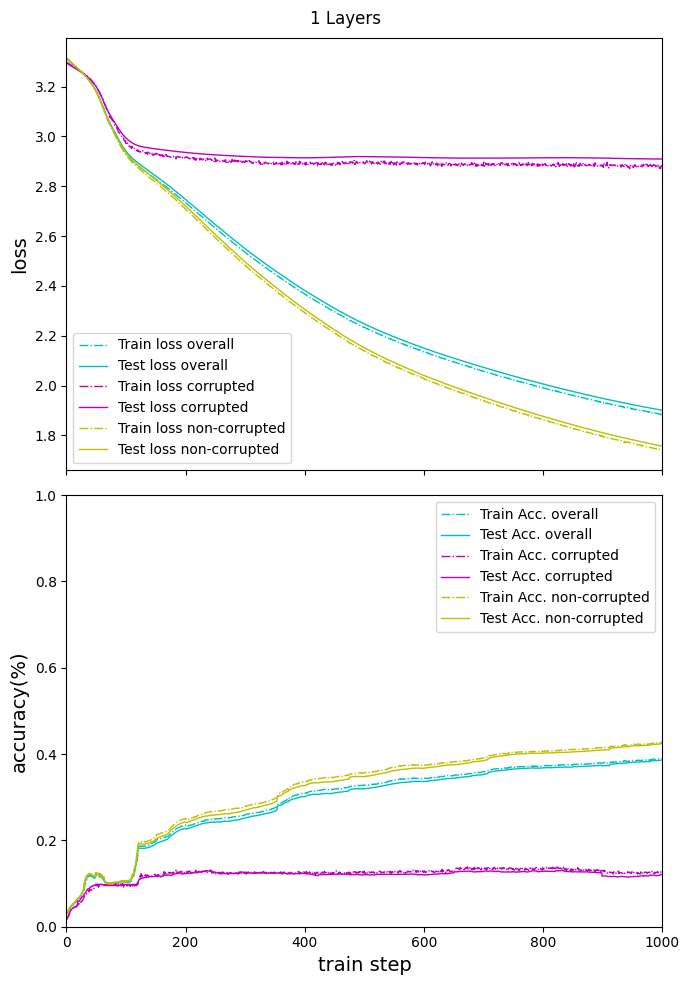

Epoch 0 	 Train Loss 3.337 	 Test Loss 3.332 	 Test Acc. (%)  1.1
Epoch 50 	 Train Loss 3.13 	 Test Loss 3.126 	 Test Acc. (%)  7.2
Epoch 100 	 Train Loss 2.93 	 Test Loss 2.943 	 Test Acc. (%)  11.7
Epoch 150 	 Train Loss 2.906 	 Test Loss 2.921 	 Test Acc. (%)  11.7
Epoch 200 	 Train Loss 2.884 	 Test Loss 2.9 	 Test Acc. (%)  12.1
Epoch 250 	 Train Loss 2.844 	 Test Loss 2.861 	 Test Acc. (%)  15.2
Epoch 300 	 Train Loss 2.796 	 Test Loss 2.816 	 Test Acc. (%)  16.9
Epoch 350 	 Train Loss 2.744 	 Test Loss 2.765 	 Test Acc. (%)  20.2
Epoch 400 	 Train Loss 2.685 	 Test Loss 2.706 	 Test Acc. (%)  21.3
Epoch 450 	 Train Loss 2.609 	 Test Loss 2.63 	 Test Acc. (%)  23.4
Epoch 500 	 Train Loss 2.53 	 Test Loss 2.549 	 Test Acc. (%)  25.3
Epoch 550 	 Train Loss 2.457 	 Test Loss 2.475 	 Test Acc. (%)  28.2
Epoch 600 	 Train Loss 2.385 	 Test Loss 2.405 	 Test Acc. (%)  29.3
Epoch 650 	 Train Loss 2.324 	 Test Loss 2.342 	 Test Acc. (%)  30.4
Epoch 700 	 Train Loss 2.268 	 Test Loss 2.28

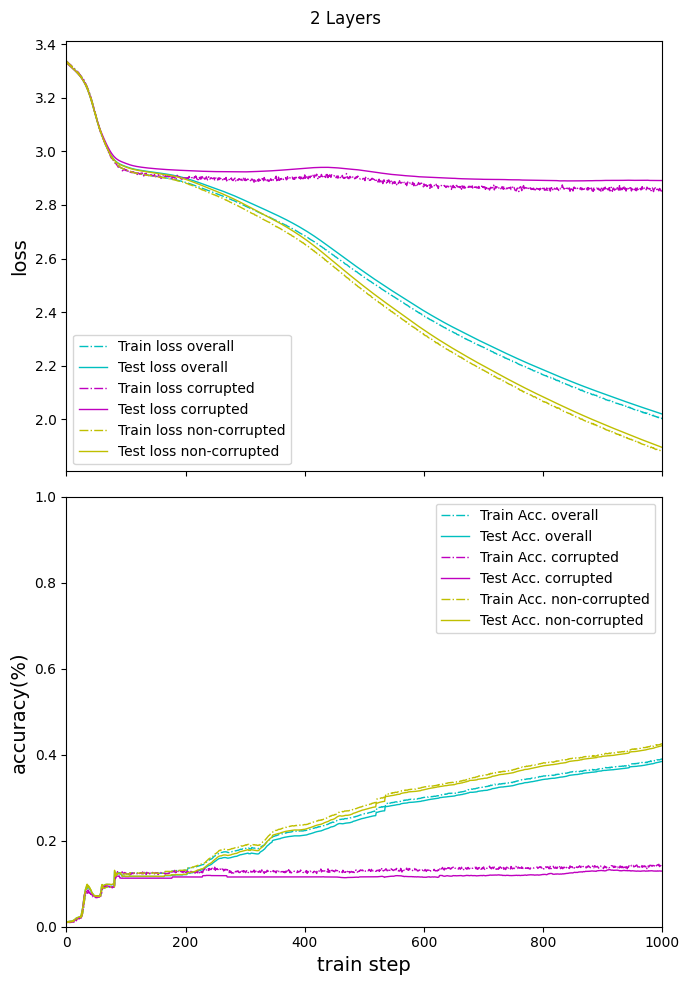

In [38]:
for n in num_layers:
    train_encrypted_dataset = CorruptedDataset(train_encrypted)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=n,
                                        num_letters=len(corr_vocab),
                                        hidden_size=16,
                                        use_lstm=True)

    num_epochs=1000
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title= str(n)+' Layers')

Epoch 0 	 Train Loss 3.289 	 Test Loss 3.276 	 Test Acc. (%)  6.7
Epoch 50 	 Train Loss 2.775 	 Test Loss 2.789 	 Test Acc. (%)  14.0
Epoch 100 	 Train Loss 2.56 	 Test Loss 2.574 	 Test Acc. (%)  23.4
Epoch 150 	 Train Loss 2.356 	 Test Loss 2.367 	 Test Acc. (%)  29.1
Epoch 200 	 Train Loss 2.213 	 Test Loss 2.224 	 Test Acc. (%)  33.0
Epoch 250 	 Train Loss 2.112 	 Test Loss 2.124 	 Test Acc. (%)  34.4
Epoch 300 	 Train Loss 2.039 	 Test Loss 2.052 	 Test Acc. (%)  35.9
Epoch 350 	 Train Loss 1.981 	 Test Loss 1.993 	 Test Acc. (%)  37.4
Epoch 400 	 Train Loss 1.944 	 Test Loss 1.953 	 Test Acc. (%)  38.6
Epoch 450 	 Train Loss 1.909 	 Test Loss 1.92 	 Test Acc. (%)  39.7
Epoch 500 	 Train Loss 1.878 	 Test Loss 1.89 	 Test Acc. (%)  40.2
Epoch 550 	 Train Loss 1.857 	 Test Loss 1.865 	 Test Acc. (%)  41.0
Epoch 600 	 Train Loss 1.833 	 Test Loss 1.843 	 Test Acc. (%)  41.8
Epoch 650 	 Train Loss 1.813 	 Test Loss 1.824 	 Test Acc. (%)  42.2
Epoch 700 	 Train Loss 1.796 	 Test Loss 

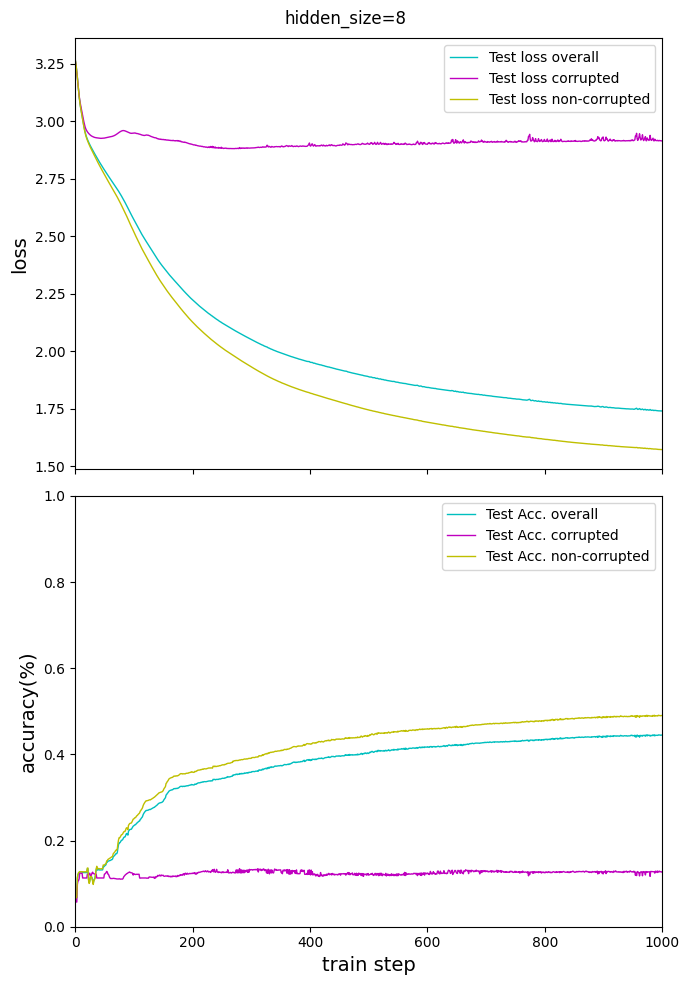

Epoch 0 	 Train Loss 3.308 	 Test Loss 3.286 	 Test Acc. (%)  5.6
Epoch 50 	 Train Loss 2.71 	 Test Loss 2.721 	 Test Acc. (%)  21.5
Epoch 100 	 Train Loss 2.251 	 Test Loss 2.26 	 Test Acc. (%)  34.3
Epoch 150 	 Train Loss 1.93 	 Test Loss 1.941 	 Test Acc. (%)  40.2
Epoch 200 	 Train Loss 1.712 	 Test Loss 1.729 	 Test Acc. (%)  45.9
Epoch 250 	 Train Loss 1.588 	 Test Loss 1.603 	 Test Acc. (%)  49.7
Epoch 300 	 Train Loss 1.476 	 Test Loss 1.492 	 Test Acc. (%)  53.4
Epoch 350 	 Train Loss 1.026 	 Test Loss 1.038 	 Test Acc. (%)  71.7
Epoch 400 	 Train Loss 0.667 	 Test Loss 0.673 	 Test Acc. (%)  83.7
Epoch 450 	 Train Loss 0.507 	 Test Loss 0.512 	 Test Acc. (%)  87.9
Epoch 500 	 Train Loss 0.439 	 Test Loss 0.447 	 Test Acc. (%)  88.9
Epoch 550 	 Train Loss 0.411 	 Test Loss 0.415 	 Test Acc. (%)  89.2
Epoch 600 	 Train Loss 0.39 	 Test Loss 0.396 	 Test Acc. (%)  89.4
Epoch 650 	 Train Loss 0.376 	 Test Loss 0.384 	 Test Acc. (%)  89.5
Epoch 700 	 Train Loss 0.374 	 Test Loss 0

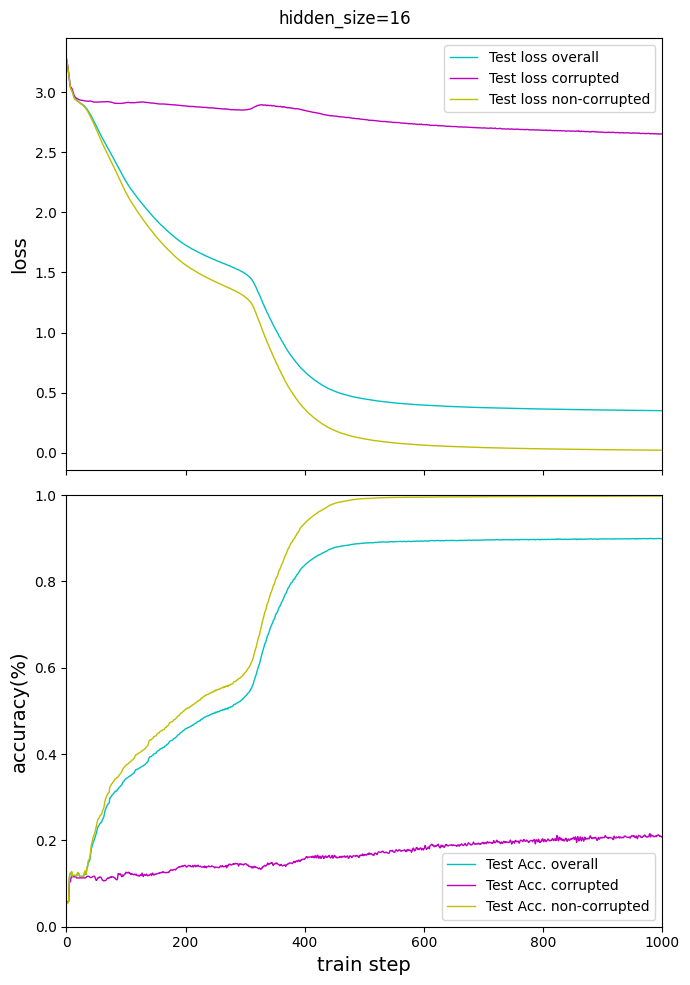

Epoch 0 	 Train Loss 3.296 	 Test Loss 3.247 	 Test Acc. (%)  6.0
Epoch 50 	 Train Loss 2.471 	 Test Loss 2.475 	 Test Acc. (%)  27.1
Epoch 100 	 Train Loss 1.901 	 Test Loss 1.909 	 Test Acc. (%)  41.2
Epoch 150 	 Train Loss 1.526 	 Test Loss 1.538 	 Test Acc. (%)  52.1
Epoch 200 	 Train Loss 0.785 	 Test Loss 0.783 	 Test Acc. (%)  80.1
Epoch 250 	 Train Loss 0.44 	 Test Loss 0.444 	 Test Acc. (%)  88.8
Epoch 300 	 Train Loss 0.378 	 Test Loss 0.381 	 Test Acc. (%)  89.6
Epoch 350 	 Train Loss 0.357 	 Test Loss 0.36 	 Test Acc. (%)  89.9
Epoch 400 	 Train Loss 0.346 	 Test Loss 0.348 	 Test Acc. (%)  90.0
Epoch 450 	 Train Loss 0.337 	 Test Loss 0.339 	 Test Acc. (%)  90.2
Epoch 500 	 Train Loss 0.332 	 Test Loss 0.333 	 Test Acc. (%)  90.2
Epoch 550 	 Train Loss 0.329 	 Test Loss 0.329 	 Test Acc. (%)  90.3
Epoch 600 	 Train Loss 0.322 	 Test Loss 0.325 	 Test Acc. (%)  90.4
Epoch 650 	 Train Loss 0.319 	 Test Loss 0.321 	 Test Acc. (%)  90.5
Epoch 700 	 Train Loss 0.318 	 Test Loss

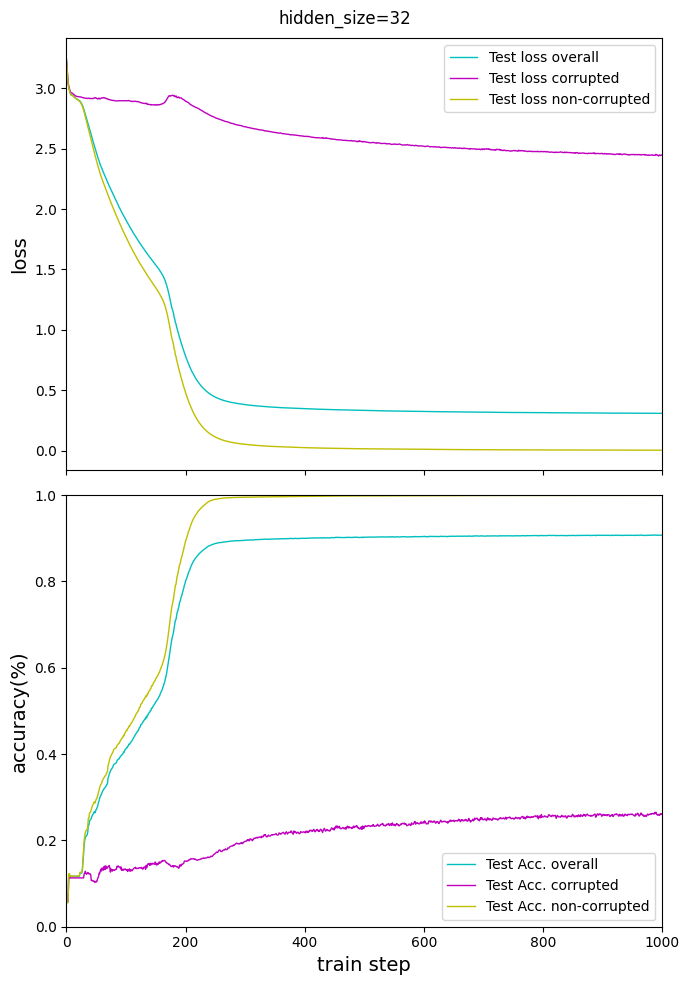

Epoch 0 	 Train Loss 3.326 	 Test Loss 3.275 	 Test Acc. (%)  8.9
Epoch 50 	 Train Loss 2.309 	 Test Loss 2.309 	 Test Acc. (%)  31.0
Epoch 100 	 Train Loss 1.051 	 Test Loss 1.033 	 Test Acc. (%)  73.2
Epoch 150 	 Train Loss 0.426 	 Test Loss 0.431 	 Test Acc. (%)  89.3
Epoch 200 	 Train Loss 0.358 	 Test Loss 0.364 	 Test Acc. (%)  89.9
Epoch 250 	 Train Loss 0.337 	 Test Loss 0.342 	 Test Acc. (%)  90.2
Epoch 300 	 Train Loss 0.327 	 Test Loss 0.33 	 Test Acc. (%)  90.3
Epoch 350 	 Train Loss 0.317 	 Test Loss 0.324 	 Test Acc. (%)  90.5
Epoch 400 	 Train Loss 0.318 	 Test Loss 0.317 	 Test Acc. (%)  90.7
Epoch 450 	 Train Loss 0.312 	 Test Loss 0.313 	 Test Acc. (%)  90.7
Epoch 500 	 Train Loss 0.305 	 Test Loss 0.31 	 Test Acc. (%)  90.8
Epoch 550 	 Train Loss 0.304 	 Test Loss 0.307 	 Test Acc. (%)  90.8
Epoch 600 	 Train Loss 0.305 	 Test Loss 0.305 	 Test Acc. (%)  90.8
Epoch 650 	 Train Loss 0.303 	 Test Loss 0.303 	 Test Acc. (%)  90.9
Epoch 700 	 Train Loss 0.302 	 Test Loss

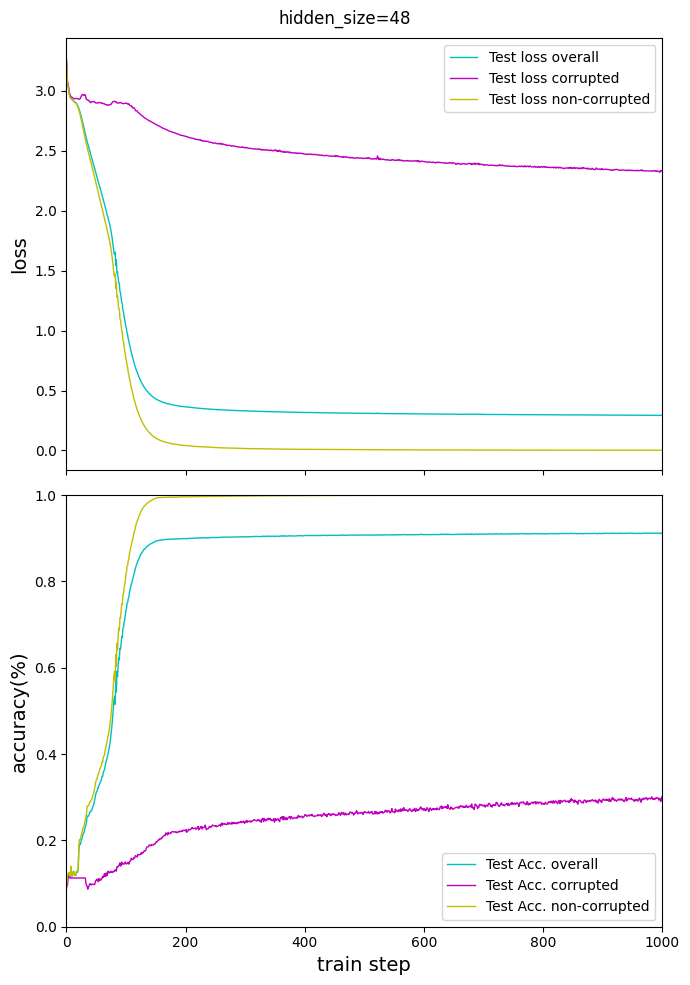

In [32]:
for h in hidden_sizes:
    train_encrypted_dataset = CorruptedDataset(train_encrypted)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=2,
                                        num_letters=len(corr_vocab),
                                        hidden_size=h,
                                        use_lstm=True)

    num_epochs=1000
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='hidden_size='+str(h))

Epoch 0 	 Train Loss 3.289 	 Test Loss 3.291 	 Test Acc. (%)  5.4
Epoch 50 	 Train Loss 3.126 	 Test Loss 3.135 	 Test Acc. (%)  9.3
Epoch 100 	 Train Loss 2.886 	 Test Loss 2.907 	 Test Acc. (%)  12.0
Epoch 150 	 Train Loss 2.774 	 Test Loss 2.815 	 Test Acc. (%)  18.2
Epoch 200 	 Train Loss 2.657 	 Test Loss 2.723 	 Test Acc. (%)  22.7
Epoch 250 	 Train Loss 2.54 	 Test Loss 2.63 	 Test Acc. (%)  25.1
Epoch 300 	 Train Loss 2.433 	 Test Loss 2.545 	 Test Acc. (%)  26.5
Epoch 350 	 Train Loss 2.34 	 Test Loss 2.472 	 Test Acc. (%)  26.8
Epoch 400 	 Train Loss 2.259 	 Test Loss 2.408 	 Test Acc. (%)  28.6
Epoch 450 	 Train Loss 2.185 	 Test Loss 2.35 	 Test Acc. (%)  29.3
Epoch 500 	 Train Loss 2.119 	 Test Loss 2.299 	 Test Acc. (%)  30.2
Epoch 550 	 Train Loss 2.059 	 Test Loss 2.253 	 Test Acc. (%)  31.8
Epoch 600 	 Train Loss 2.001 	 Test Loss 2.211 	 Test Acc. (%)  32.6
Epoch 650 	 Train Loss 1.947 	 Test Loss 2.173 	 Test Acc. (%)  33.2
Epoch 700 	 Train Loss 1.896 	 Test Loss 2.

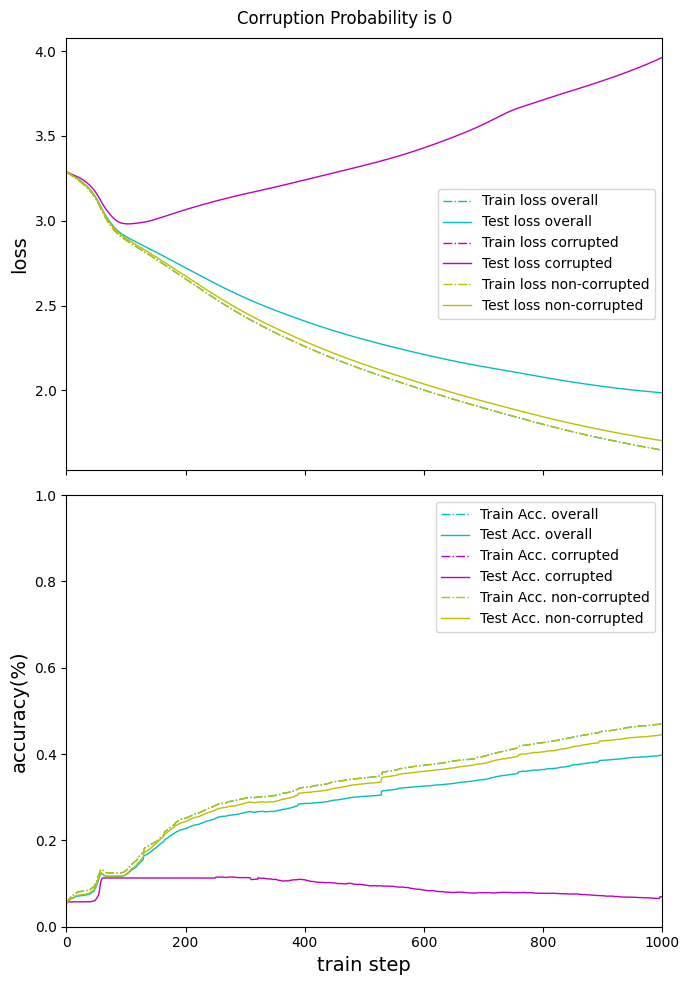

Epoch 0 	 Train Loss 3.342 	 Test Loss 3.338 	 Test Acc. (%)  3.6
Epoch 50 	 Train Loss 3.178 	 Test Loss 3.177 	 Test Acc. (%)  10.0
Epoch 100 	 Train Loss 2.917 	 Test Loss 2.928 	 Test Acc. (%)  12.2
Epoch 150 	 Train Loss 2.846 	 Test Loss 2.859 	 Test Acc. (%)  15.6
Epoch 200 	 Train Loss 2.767 	 Test Loss 2.78 	 Test Acc. (%)  18.5
Epoch 250 	 Train Loss 2.676 	 Test Loss 2.689 	 Test Acc. (%)  21.5
Epoch 300 	 Train Loss 2.579 	 Test Loss 2.593 	 Test Acc. (%)  23.6


In [ ]:
for c in corruptions:
    train_encrypted_dataset = CorruptedDataset(train_encrypted, p=c)
    train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

    decrypter_network = CorruptedDecrypterNetwork(num_layers=1,
                                        num_letters=len(corr_vocab),
                                        hidden_size=16,
                                        use_lstm=True)

    num_epochs=1000
    optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

    decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                                num_epochs,
                                                                CE_loss,
                                                                optimizer,
                                                                train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

    plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='Corruption Probability is '+str(c))

### Definitive Parameters



In [18]:
def_epochs = 1000
def_learning_rate = 1e-2
def_use_lstm = True
def_num_layer = 2
def_hidden_size = 32
def_corruption = 0.125

In [19]:
train_encrypted_dataset = CorruptedDataset(train_encrypted, p=def_corruption)
train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

decrypter_network = CorruptedDecrypterNetwork(num_layers=def_num_layer,
                                    num_letters=len(corr_vocab),
                                    hidden_size=def_hidden_size,
                                    use_lstm=def_use_lstm)

num_epochs=def_epochs
CE_loss = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=def_learning_rate)

decrypter_network, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_test(decrypter_network,
                                                            num_epochs,
                                                            CE_loss,
                                                            optimizer,
                                                            train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

plot_loss_accuracy(train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, title='Final Model')

Epoch 0 	 Train Loss 3.333 	 Test Loss 3.282 	 Test Acc. (%)  7.2
Epoch 50 	 Train Loss 2.453 	 Test Loss 2.46 	 Test Acc. (%)  26.4
Epoch 100 	 Train Loss 1.932 	 Test Loss 1.936 	 Test Acc. (%)  39.6
Epoch 150 	 Train Loss 1.578 	 Test Loss 1.583 	 Test Acc. (%)  50.1
Epoch 200 	 Train Loss 1.015 	 Test Loss 1.01 	 Test Acc. (%)  72.4
Epoch 250 	 Train Loss 0.471 	 Test Loss 0.476 	 Test Acc. (%)  88.7
Epoch 300 	 Train Loss 0.383 	 Test Loss 0.39 	 Test Acc. (%)  89.7
Epoch 350 	 Train Loss 0.361 	 Test Loss 0.364 	 Test Acc. (%)  89.9
Epoch 400 	 Train Loss 0.347 	 Test Loss 0.35 	 Test Acc. (%)  90.1
Epoch 450 	 Train Loss 0.342 	 Test Loss 0.341 	 Test Acc. (%)  90.2
Epoch 500 	 Train Loss 0.332 	 Test Loss 0.334 	 Test Acc. (%)  90.3
Epoch 550 	 Train Loss 0.328 	 Test Loss 0.33 	 Test Acc. (%)  90.4
Epoch 600 	 Train Loss 0.325 	 Test Loss 0.327 	 Test Acc. (%)  90.4
Epoch 650 	 Train Loss 0.32 	 Test Loss 0.323 	 Test Acc. (%)  90.5
Epoch 700 	 Train Loss 0.315 	 Test Loss 0.3